# <center> 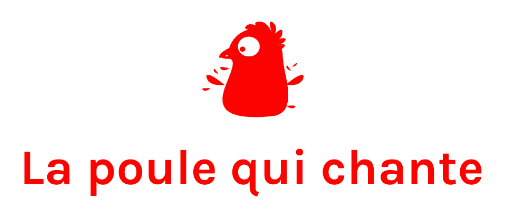

# <center> Clustering et Analyse

### Sommaire:

* [I) Introduction](#chapter1)

    * [1) Importation des librairies et déclarations des fonctions](#section_1_1)
    * [2) Importation des données](#section_1_2)
    
* [II) Exploration des données](#chapter2)

    * [1) Réduction des dimensions - ACP](#section_2_1)
    * [2) Interprétation des composantes](#section_2_2)
    * [3) Visualisations](#section_2_3)
    
* [III) Clustering](#chapter3)
    * [1) Méthode K-Means](#section_3_1)
    * [2) Méthode CAH](#section_3_2)
    * [3) Comparaison des résultats](#section_3_3)

* [IV) Interprétation & Recommandations](#chapter4)

## I) Introduction <a class="anchor" id="chapter1"></a>

Après avoir préparé nos données nous allons pouvoir les analyser et procéder au clustering afin de déterminer les premiers groupes de pays susceptibles d'être de bons candidats pour un lancement à l'international.


### 1. Importation des librairies et déclarations des fonctions: <a class="anchor" id="section_1_1"></a>

In [24]:
# import des librairies:

import pandas as pd
from pandas.plotting import parallel_coordinates

import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import seaborn as sns

# "chargement" de seaborn:
sns.set()
palette = sns.color_palette("bright", n_colors=15)

> **Fonctions - ACP:**

In [25]:
def pca_éboulis(df, n_components):
    
    """Affiche l'éboulis des valeurs après avoir réalisé une PCA sur le df indiqué"""

# on crée la matrice des données
    X = df.values

# on enregistre les individus dans une variable "names" ...
    names = df.index

# ... et les colonnes/features, dans une variables "features"
    features = df.columns
    
# on instancie
    scaler = StandardScaler()

# on fit
    scaler.fit(X)

# on transforme
    X_scaled = scaler.transform(X)

# on instancie notre ACP
    pca = PCA(n_components = n_components)

# on l'entraine sur les données scalées
    pca.fit(X_scaled)

# on enregistre le pourcentage de la variance attribuée à chacune des composantes dans une variable "sree"
    scree = (pca.explained_variance_ratio_*100)

## on calcule la somme cumulée de ces variances
    scree_cum = scree.cumsum().round()

# on définit une variable avec la liste de nos composantes
    x_list = range(1, n_components+1)

# on fait la représentation graphique de l'ébloulis des valeurs propres
    plt.bar(x_list, scree)
    plt.plot(x_list, scree_cum,c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [26]:
def pca_composantes(df, n_components):
    
    """"Affiche les composantes sous forme de heatmap"""

# on crée la matrice des données
    X = df.values

# on enregistre les individus dans une variable "names" ...
    names = df.index

# ... et les colonnes/features, dans une variables "features"
    features = df.columns

# on instancie
    scaler = StandardScaler()

# on fit
    scaler.fit(X)

# on transforme
    X_scaled = scaler.transform(X)

# on instancie notre ACP
    pca = PCA(n_components = n_components)

# on l'entraine sur les données scalées
    pca.fit(X_scaled)
    
# on définit une variable avec la liste de nos composantes
    x_list = range(1, n_components+1)

# on calcul les composantes
    pcs = pca.components_
    
# on passe en version pandas    
    pcs = pd.DataFrame(pcs)
    pcs.columns = features
    pcs.index = [f"F{i}" for i in x_list]

# affichage en "heatmap" de la matrice des composantes
    fig, ax = plt.subplots(figsize=(20, 8))
    sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

In [27]:
def pca_cercle(df, n_components, x_y, label_size=10, figsize=[10,8]) : 
    
    """Affiche le cercle des correlations"""

# on crée la matrice des données
    X = df.values

# on enregistre les individus dans une variable "names" ...
    names = df.index

# ... et les colonnes/features, dans une variables "features"
    features = df.columns

# on instancie
    scaler = StandardScaler()

# on fit
    scaler.fit(X)

# on transforme
    X_scaled = scaler.transform(X)

# on instancie notre ACP
    pca = PCA(n_components = n_components)

# on l'entraine sur les données scalées
    pca.fit(X_scaled)
    
    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=figsize)

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.03,
                head_length=0.03, 
                width=0.01, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.02,
                pca.components_[y, i] + 0.02,
                features[i],
                fontsize=label_size)
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [28]:
def pca_nuage(df, n_components, x_y, labels=None, clusters=None, alpha=1, figsize=[10,8], marker="." ):
    
    """Affiche la projection des individus"""

# on crée la matrice des données
    X = df.values

# ... et les colonnes/features, dans une variables "features"
    features = df.columns

# on instancie
    scaler = StandardScaler()

# on fit
    scaler.fit(X)

# on transforme
    X_scaled = scaler.transform(X)

# on instancie notre ACP
    pca = PCA(n_components = n_components)

# on l'entraine sur les données scalées
    pca.fit(X_scaled)
    
    # on calcule les coordonnées de nos individus dans le nouvel espace
    X_proj = pca.transform(X_scaled)
    X_proj[:5]
    
    # Transforme X_projected en np.array
    X_ = np.array(X_proj)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

> **Fonctions - Corrélation:**

In [29]:
def correlation_heatmap(df,figsize=[30,15], cmap="viridis"):
    
    """"Affiche la matrice des corrélations"""

    correlation = df.corr()
    plt.figure(figsize=figsize)
    sns.heatmap(correlation, vmax=1, vmin=-1, square=True, annot=True, fmt=".3f", cmap=cmap)
    plt.title('Tableau de corrélation entre variables')
    plt.show()

> **Fonctions - Nombre de clusters:**

In [30]:
def coude_fct(df, num_clusters, random_state=42):

    kmeans_tests = [KMeans(n_clusters=i, init="random", n_init=100, random_state=random_state) for i in range(1, num_clusters)]
    score = [kmeans_tests[i].fit(df).score(df) for i in range(len(kmeans_tests))]

    plt.figure(figsize=(14,10))
    plt.plot(range(1, num_clusters),score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.show()

In [31]:
def coeff_silhouette(df, n=15, random_state=42):
    
    """Affiche la courbe du coefficient de silhouette ainsi que les scores"""

    tab_silhouette =[]
    k_range=range(2,n)
    for k in k_range:
        model=KMeans(n_clusters=k, init="random", n_init=200, random_state=random_state)
        cluster_labels=model.fit_predict(df)
        tab_silhouette.append(silhouette_score(df,cluster_labels))

    fig = plt.figure(figsize=(14,6))
    plt.plot(k_range,tab_silhouette)
    plt.xlabel('nombre de clusters')
    plt.ylabel('Coefficient de silhouette')
    plt.grid()
    plt.show()
    return(tab_silhouette)

> **Fonctions - Projection:**

In [32]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None, figsize=(14,14)):
    
    """"Affiche un nuage de point clusterisé sur le plan factoriel indiqué"""

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=figsize)
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)

> **Fonction - Analyse des centroides:**

In [33]:
def display_parallel_coordinates_centroids(df, num_clusters=None, lw=1):
    
    """Affiche un parallel coordinates des centroides"""

    # Create the plot
    fig = plt.figure(figsize=(16, 10))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'Cluster', color=palette, lw=lw)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20) 

> **Fonction - Dendrogramme:**

In [34]:
def dendrogram_fct (df, figsize=(20,10), orientation="top", p=None, fontsize=8):
    
    """Affiche un dendrogramme vertical"""

    Z=linkage(df, 'ward')
    plt.figure(figsize=figsize)
    plt.title('Dendrogramme - Classification Ascendante Hierarchique')
    plt.xlabel('Distance')
    dendrogram(Z=Z, labels = df.index, orientation = orientation, p=p, truncate_mode="lastp")
    plt.xticks(rotation = 45, fontsize=fontsize)

### 2. Importation des données: <a class="anchor" id="section_1_2"></a>

In [35]:
# import des données:
data = pd.read_csv("data_p9_vf.csv", index_col=0)
data.head()

,Population,Evo population (%),Population urbaine (%),Evo population urbaine (%),Disponibilité (tonnes),Disponibilité (kg/habitant),Evo disponibilité (%),Importations (tonnes),Taux importation (%),Evo taux importation,Taux production (%),Evo taux production,PIB,Evo PIB (%),PIB/habitant,Stabilité politique,Evo stabilité politique (%),CPI,Evo CPI
Pays,,,,,,,,,,,,,,,,,,,
Afghanistan,38972230.0,12.518758,25.413832,14.224503,67968.0,1.630779,6.119736,35473.0,56.040986,-3.189270,43.959392,3.189648,1.979326e+04,9.843217,508.453722,-2.73,-0.06,19.0,4.0
Afrique du Sud,58801927.0,4.217577,67.261212,8.059639,2029917.0,37.865119,6.604877,478091.0,17.916718,-4.973859,84.132166,3.798755,3.021412e+05,1.957287,5094.384038,-0.24,-0.10,44.0,-1.0
Albanie,2866849.0,-0.493360,63.741132,6.887590,36860.0,12.465637,-3.046392,24158.0,65.766920,0.227039,34.233080,-0.227039,1.490962e+04,25.699109,5180.914198,0.08,-0.26,36.0,-3.0
Algérie,43451666.0,7.715391,73.532071,10.112844,270285.0,5.976774,-2.612329,1.0,0.000189,-0.000186,100.218717,0.219092,1.476887e+05,-7.714299,3367.963003,-0.86,0.24,36.0,2.0
Allemagne,83328988.0,1.211646,76.720367,1.063631,900507.0,15.391329,12.424955,447257.0,36.713002,-2.492556,83.116064,-4.460198,3.846414e+06,10.927647,45908.724713,0.67,-0.01,80.0,-1.0


In [36]:
data.describe()

,Population,Evo population (%),Population urbaine (%),Evo population urbaine (%),Disponibilité (tonnes),Disponibilité (kg/habitant),Evo disponibilité (%),Importations (tonnes),Taux importation (%),Evo taux importation,Taux production (%),Evo taux production,PIB,Evo PIB (%),PIB/habitant,Stabilité politique,Evo stabilité politique (%),CPI,Evo CPI
count,1.820000e+02,182.000000,182.000000,182.000000,1.820000e+02,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,1.820000e+02,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,4.284320e+07,4.962141,59.002435,8.139906,5.563800e+05,22.229538,18.568216,62684.150495,36.907598,-0.015678,73.482741,0.587576,4.646264e+05,13.092663,13328.718292,-0.134246,-0.013743,43.517241,0.450292
std,1.525440e+08,4.788790,22.420363,6.379763,1.734532e+06,18.010634,36.676101,137590.646371,38.216292,19.088869,52.814175,16.037150,1.970615e+06,33.909373,18944.811360,0.939028,0.292231,18.126542,3.615748
min,4.764200e+04,-9.518010,11.984740,-3.519473,1.567000e+03,0.512920,-71.227104,0.000000,0.000000,-190.607321,0.000000,-58.299573,1.809138e+02,-63.137617,285.875782,-2.730000,-0.870000,12.000000,-9.000000
25%,2.771691e+06,1.329072,40.256916,3.237348,2.320425e+04,6.697196,2.580332,1453.750000,3.377530,-1.091076,35.302082,-2.629126,1.200169e+04,0.195496,1882.878570,-0.657500,-0.160000,30.000000,-2.000000
50%,9.936168e+06,4.847244,59.058755,6.966441,8.958250e+04,19.761943,8.541902,11910.000000,20.125556,0.020555,85.470359,-0.064011,4.124389e+04,10.857602,5137.649118,-0.085000,-0.020000,40.500000,0.000000
75%,3.225813e+07,8.420228,76.638143,12.494763,3.232530e+05,32.648607,24.574139,54711.000000,70.601289,2.450702,99.816875,1.683043,2.478744e+05,22.044573,15446.528100,0.647500,0.150000,54.750000,2.000000
max,1.424930e+09,16.307896,102.851227,25.528068,1.537409e+07,84.686214,330.387022,860864.000000,191.634924,88.429333,524.916659,135.107445,2.089375e+07,385.383626,117181.646629,1.490000,0.820000,88.000000,16.000000


## II) Exploration des données <a class="anchor" id="chapter2"></a>

Nous allons d'abord approfondir l'exploration de nos données, que ce soit au niveau des individus mais aussi des variables. 

Pour cela nous allons utiliser l'**Analyse en Composantes Principales**. Cette méthode, grâce à la réduction de dimensions qu'elle réalise, va nous permettre d'obtenir une visualisation optimale de nos données mais aussi d'interpréter les relations entre nos variables.

### 1. Réduction des dimensions - ACP: <a class="anchor" id="section_2_1"></a>

Pour la réalisation d'une ACP nous devons au préalable standardiser nos données afin d'équilibrer le "poids" de chaque individus.

On choisit ici la méthode de **normalisation standard** qui consiste à soustraire la moyenne puis diviser par l'écart-type.

In [37]:
# On standardise nos données:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled

array([[-0.02544613,  1.58233369, -1.50226211, ..., -0.15872586,
        -1.3562915 ,  0.98444362],
       [ 0.10490581, -0.15590943,  0.3693767 , ..., -0.29598156,
         0.02670616, -0.4022109 ],
       [-0.26278743, -1.14236589,  0.21193986, ..., -0.84500435,
        -0.41585309, -0.95687272],
       ...,
       [ 1.92670595, -0.48026884,  1.00863994, ..., -1.39402714,
         1.29906401, -2.06619634],
       [ 0.48872998,  1.32703944, -1.70526982, ..., -0.36460941,
        -0.30521328,  0.98444362],
       [-0.27708928,  1.06420772, -1.60561395, ...,  0.4932387 ,
        -0.08393365, -0.12488   ]])

In [38]:
# on peut vérifier nos résultats, chaque moyenne devrait être égale à 0 et l'écart-type à 1:
idx = ["mean", "std"]
pd.DataFrame(data_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
mean,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [39]:
# On peut ensuite créer notre modèle d'ACP et l'appliquer à nos données "scalées":
n_components=18
pca = PCA(n_components)
data_reduced = pca.fit_transform(data_scaled)

# On peut passer le résultat en dataframe afin de mieux le visualiser
data_reduced_df = pd.DataFrame(data_reduced, index=data.index, columns=['PC' + str(i+1) for i in range(n_components)])
data_reduced_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
Pays,,,,,,,,,,,,,,,,,,
Afghanistan,-3.581028,0.617696,0.058843,1.361179,0.025481,-0.586035,-0.275675,-0.057294,0.409537,-0.429466,-0.437726,-0.001857,-0.432821,-0.378843,1.476370,0.187534,0.114477,-0.541399
Afrique du Sud,1.071967,1.142673,-0.329968,1.607636,-0.479650,0.176023,-0.076617,-0.217263,0.380672,1.200817,-0.203969,0.036496,2.073285,-0.143528,-0.231542,-0.386655,-0.175459,-0.006498
Albanie,0.000072,-0.687218,-0.204558,-0.103313,-0.394445,0.682023,0.036434,1.091927,0.981826,-0.071661,-0.428786,1.206601,-0.438773,-0.216614,-0.600242,-0.136293,-0.256387,0.031291
Algérie,-0.992953,0.449818,1.046942,0.049814,-0.322024,-0.570151,-0.692878,-0.742929,-0.897237,0.366088,-0.849572,0.060227,-0.468614,0.012898,-0.292858,0.057552,0.229190,-0.215533
Allemagne,3.480799,1.005456,-0.618312,0.565262,0.851783,-0.223779,1.288079,-0.447803,-0.520010,0.372362,-0.386719,1.216411,1.073442,-1.028163,0.416307,-0.369978,-0.257166,-0.490233


Nos individus sont désormais exprimés au travers de "nouvelles variables", les composantes principales, chacune expliquant de manière décroissante la variabilité, l'inertie, au sein de notre de notre jeu de données.

Grâce à **l'éboulis des valeurs** nous allons pouvoir visualiser le pourcentage d'inertie expliqué par chaque axe (composante):

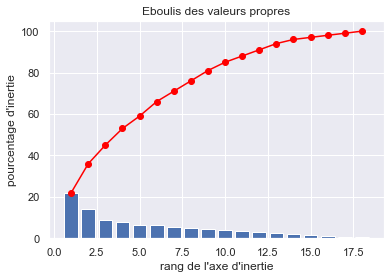

In [40]:
pca_éboulis(data, 18)

On constate qu'**une très large partie (~80%) de l'inertie de notre jeu de données peut-être expliquée au travers des 9 premières composantes** générées par l'ACP.

On choisit donc de réduire notre analyse à 9 composantes pour la suite:

In [41]:
# on peut aussi chercher à connaitre plus précisemment l'inertie expliquée par chaque composantes:
pca.explained_variance_ratio_

array([0.21880722, 0.1404203 , 0.09016068, 0.07840324, 0.06632163,
       0.06200123, 0.05653643, 0.05106556, 0.04564411, 0.03953105,
       0.0336445 , 0.0283311 , 0.02456046, 0.02053245, 0.01503814,
       0.01030685, 0.00843751, 0.00603313])

On peut aussi s'intéresser à nos variables initiales observer leurs influences sur les composantes générées, notamment afin de donner du sens à ces dernières et comprendre ce qui se trouve derrière:

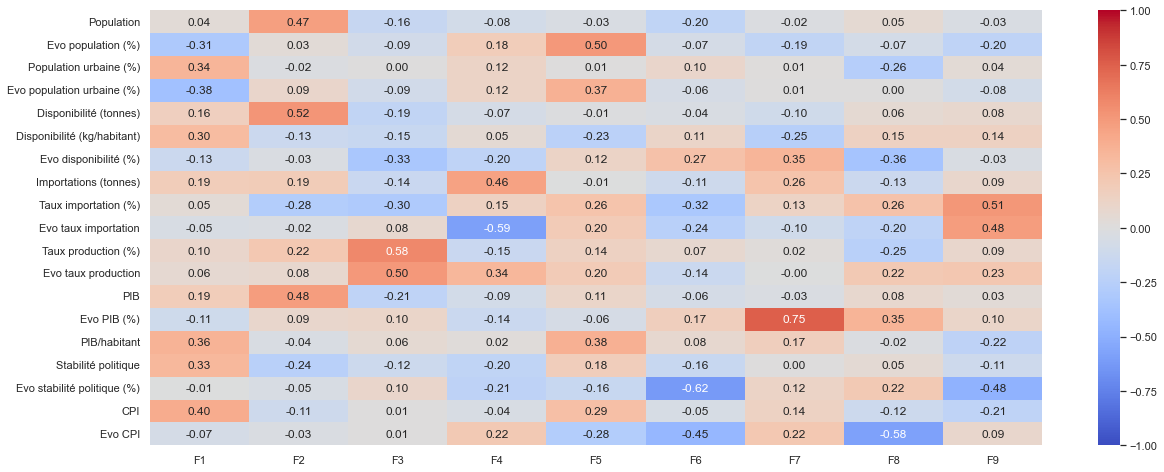

In [42]:
pca_composantes(data, 9)

Grâce à cette heatmap on peut avoir une première lecture des facteurs qui influencent le plus l'inertie de nos données, et de leurs "sources".

On peut aussi étudier les éventuelles corrélations entre nos variables:

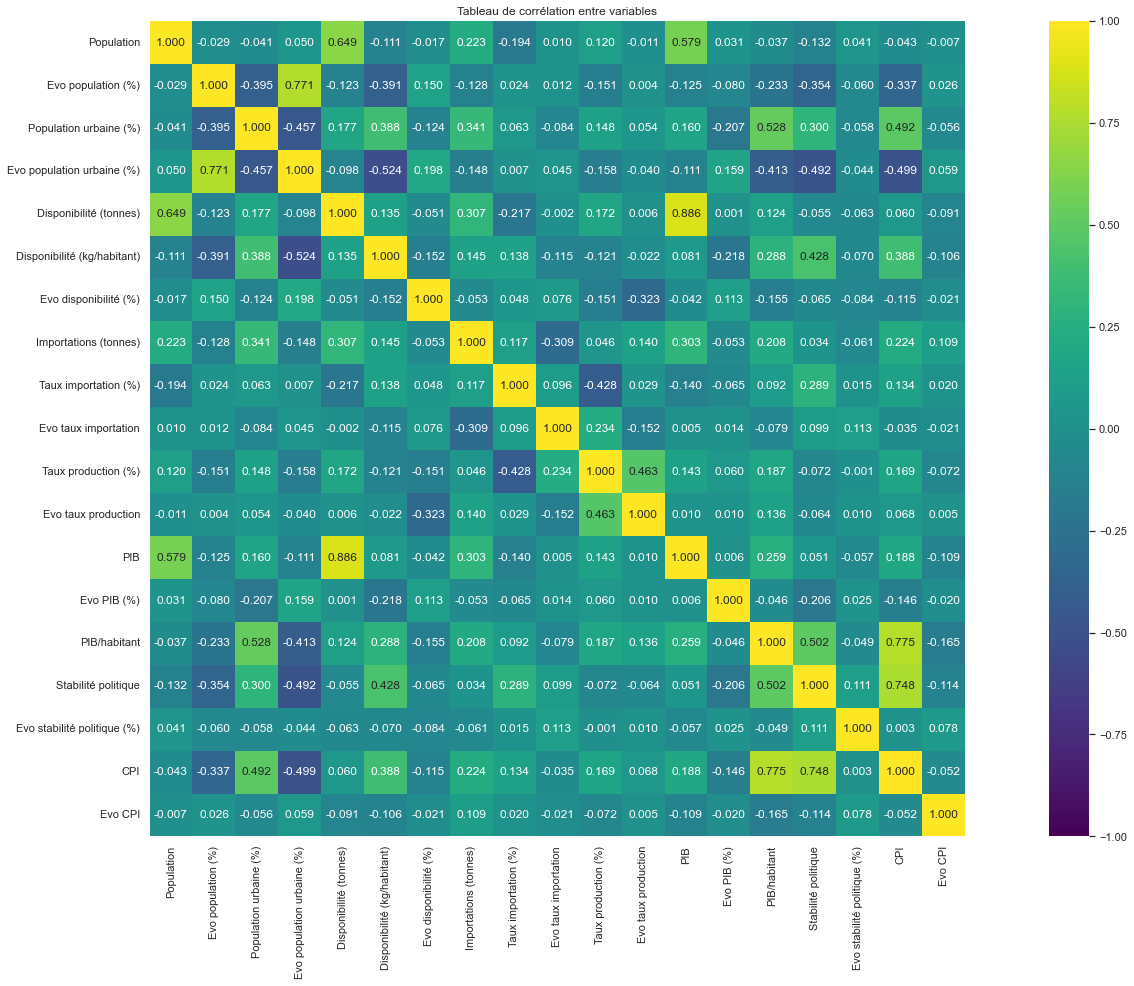

In [43]:
correlation_heatmap(data)

### 2. Interprétation des composantes: <a class="anchor" id="section_2_2"></a>

Une représentation graphique peut nous aider à préciser la lecture de nos variables et de leurs relations. Pour cela, nous pouvons "projeter" les scores de la heatmap des composantes sur les plans factoriels issus des composantes de l'ACP:

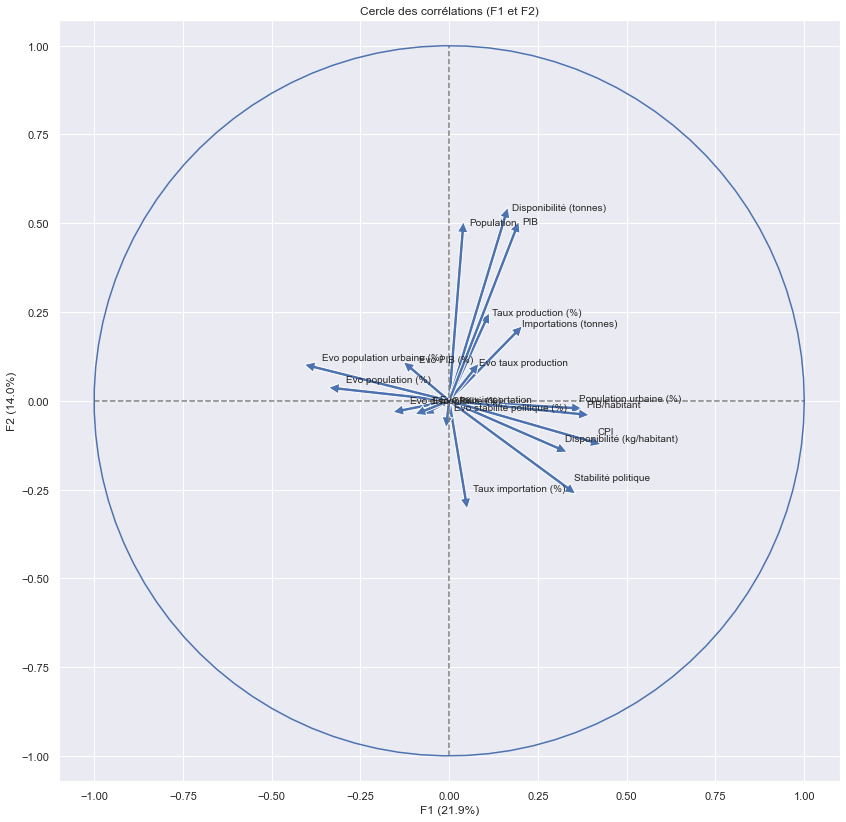

In [44]:
pca_cercle(data, 9, (0,1), figsize=[14,14])

**F1**, notre première composante (ici en abcisse) semble opposer des variables liées à l'évolution démographique (évolution population & population urbaine) sur la gauche à des variables symboles de développement (CPI, PIB/habitant, Stabilité politique, Disponibilité) sur la droite. On pourrait ainsi interpréter cette composante comme un facteur représentatif du **niveau de développement** des pays.

**F2** est principalement influencée par le volume de disponibilité, le nombre d'habitants et le PIB. Connaissant les corrélations existantes entre ces variales cette composante est plutôt bien représentative de la **taille** des pays et des marchés potentiels qu'ils représentent.

On peut ensuite s'intéresser à la projection de nos variables sur les autres plans et affiner notre lecture et notre interprétation des différentes composantes:

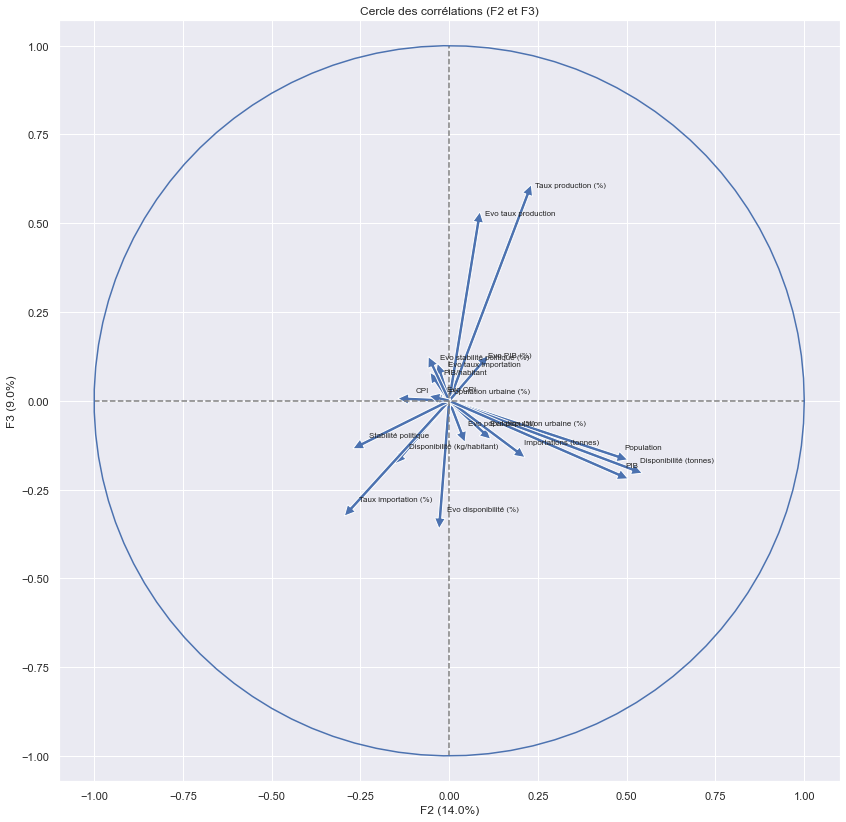

In [45]:
pca_cercle(data, 9, (1,2), label_size=8, figsize=[14,14])

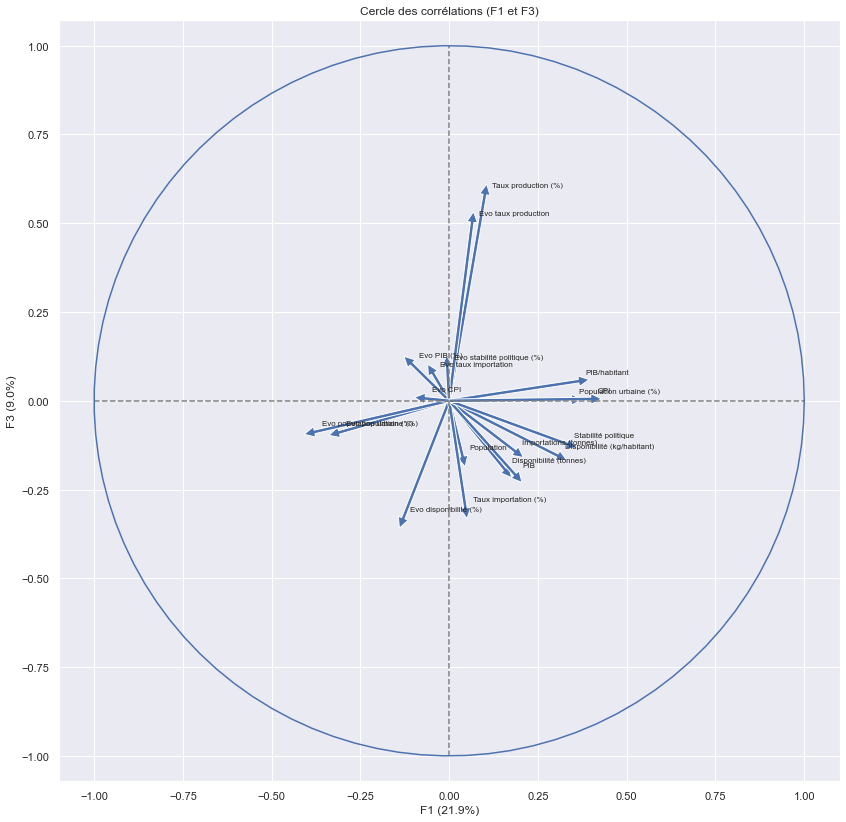

In [46]:
pca_cercle(data, 9, (0,2), label_size=8, figsize=[14,14])

Suite à toutes ces observations, comprendre ces composantes, que l'on peut aussi voire comme des variables synthétiques, est devenu plus facile et nous pouvons à présent leur donner une interprétation:

- **F1**, comme vu précédemment, représente le **Niveau de développement**.
- **F2** marque la **Taille**.
- **F3** représente le niveau d'**Auto-suffisance**.
- **F4** est principalement représentatif du **Développement de la production**.
- **F5**, correspond au **Développement démographique**.
- **F6** associe chute de la stabilité politique et de l'index de corruption. On pourrait la traduire par **Crise politique**.
- **F7** marque clairement le niveau de **Croissance économique**.

F8 & F9 sont beaucoup moins intéressants à interpréter, et ne participe respectivement qu'à 5 et 4% de l'inertie de nos données. Nous choissons de nous en passer pour notre étude, nos **7 composantes** restantes permettant d'expliquer plus de 70% de l'inertie de nos données.

***

Nous pouvons aussi, grâce aux propriétés de l'ACP, projeter nos individus dans un plan en 2D et observer leur répartition:

### 3. Visualisations: <a class="anchor" id="section_2_3"></a>

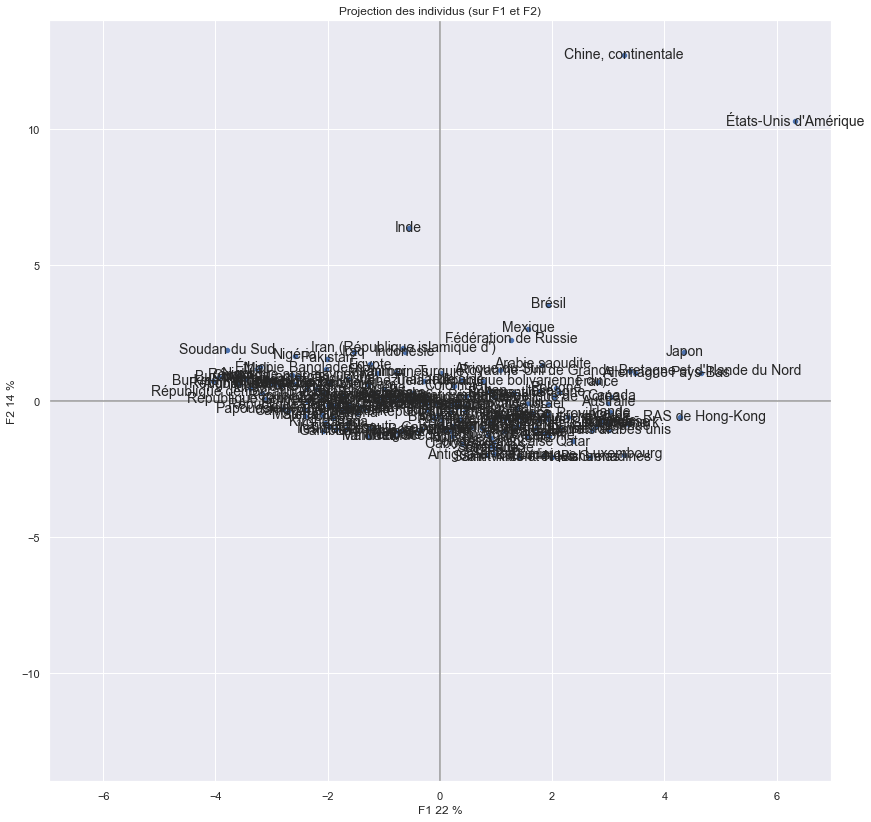

In [47]:
names = data.index
pca_nuage(data, 9, (0,1), labels=names, figsize=[14,14], marker="o" )

Grâce à l'ACP il s'agit ici de la "meilleure" représentation dans l'espace de nos données, celle qui maximise l'inertie de notre jeu de données et donc visuellement sa "dispersion".

Seul bémol, 3 outliers, que sont la Chine, les États Unis et l'Inde (voire même le Brésil) ont potentillement tendance à écraser visuellement nos données:

In [48]:
out = data[(data.index.isin(["Chine, continentale"]))|
          (data.index.isin(["États-Unis d'Amérique"]))|
          (data.index.isin(["Inde"]))|
          (data.index.isin(["Brésil"]))]
out

,Population,Evo population (%),Population urbaine (%),Evo population urbaine (%),Disponibilité (tonnes),Disponibilité (kg/habitant),Evo disponibilité (%),Importations (tonnes),Taux importation (%),Evo taux importation,Taux production (%),Evo taux production,PIB,Evo PIB (%),PIB/habitant,Stabilité politique,Evo stabilité politique (%),CPI,Evo CPI
Pays,,,,,,,,,,,,,,,,,,,
Brésil,2.131963e+08,3.063298,87.345356,4.224268,9022582.00,46.403869,6.622160,3119.00,0.052116,0.018502,139.364142,-3.274178,1.444733e+06,-19.544544,6796.844058,-0.420000,-0.040000,38.0,-2.0
"Chine, continentale",1.424930e+09,1.643503,61.411863,9.894194,13542666.00,11.586502,24.852779,569132.00,9.249862,4.945930,91.725809,-5.303752,1.472280e+07,31.063742,10228.970558,-0.134246,-0.013743,42.0,2.0
Inde,1.396387e+09,4.314151,34.596326,9.947148,3435398.05,2.540623,3.268777,7.02,0.004596,0.004392,100.082933,-0.028945,2.664749e+06,16.334549,1930.971218,-0.860000,0.090000,40.0,0.0
États-Unis d'Amérique,3.359420e+08,2.668561,81.554297,3.879464,15374094.00,50.632528,8.642517,60280.00,0.388843,0.003827,120.462912,0.969474,2.089375e+07,11.760511,63122.594145,-0.020000,-0.420000,67.0,-7.0


On distingue tout de même certains groupements se dessiner:
- Le Japon, l'Allemagne, le UK, sur la droite
- Le Mexique, la Russie qui tendent vers nos "outliers"
- Hong-Kong qui se détache seul
- Le Soudan du Sud à gauche

Au vue des interprétations que nous avons fait de F1 et F2 on peut déjà comprendre certaines choses, mais ce premier plan ne présentant que 36% de l'inertie de nos données de nombreuses informations nous échappent encore.

***

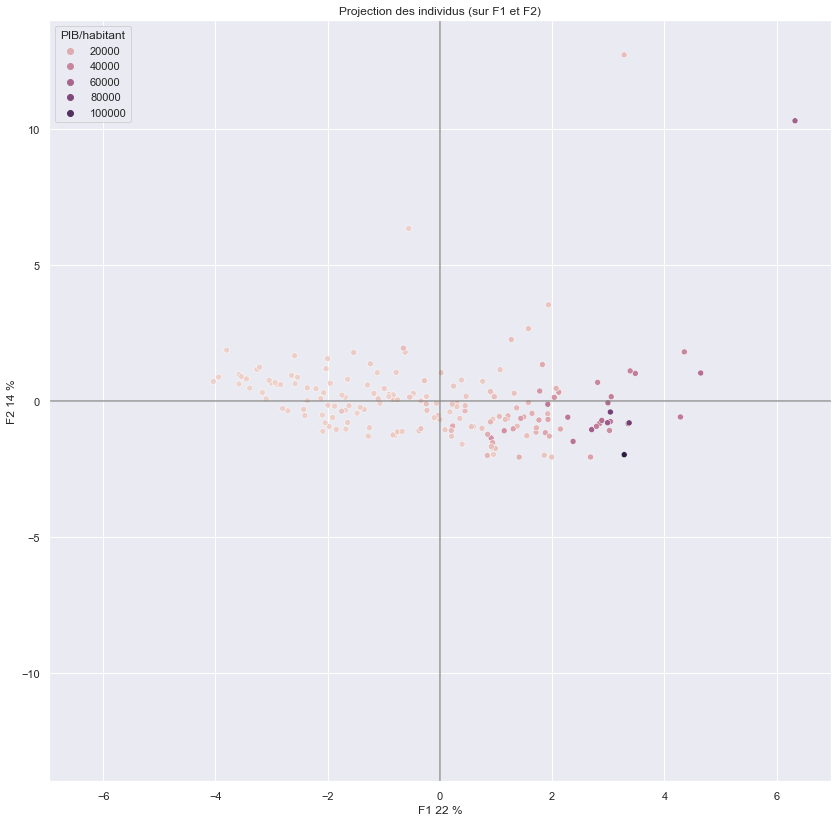

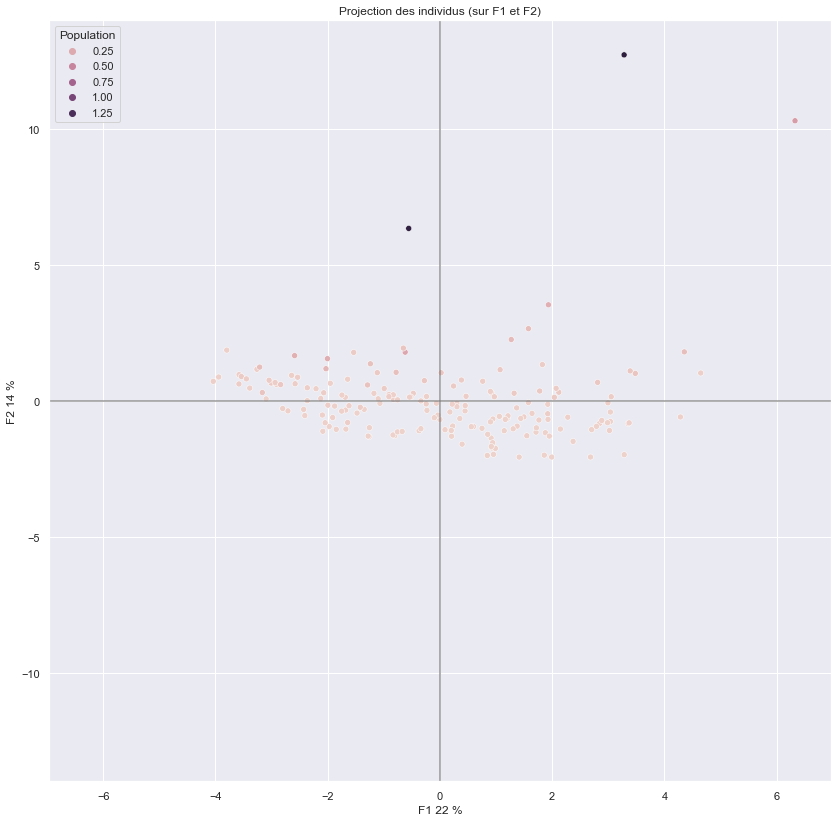

In [51]:
pca_nuage(data, 7, (0,1), clusters=data["PIB/habitant"], figsize=[14,14], marker="o" )
pca_nuage(data, 7, (0,1), clusters=data["Population"], figsize=[14,14], marker="o" )

En appliquant des bins de nos variables on visualise mieux la répartition de nos individus. Cela nous permet aussi de confirmer les interprétations faites de nos composantes.

***

Il est aussi important de garder en tête ce qu'on pourrait appeler "les variables représentées" par les facteurs dans nos analyses futures.

De plus il est à noter que certaines d'entre elles seront peut-être moins déterminantes que d'autres du fait des facteurs et phénomènes qu'elles représentent. Par exemple, nous porterons une attention toute particulière aux composantes 1 et 3, puisque elles permettent de qualifier le "développement" d'un pays ainsi que sa dépendance à une production extérieure, deux facteurs très important dans notre étude, comme cela a été présenté précédemment.

***

Nous pouvons désormais transformer notre jeu de données et utiliser nos composantes comme **variables synthétiques**:

In [53]:
data_scaled = scaler.fit_transform(data)
pca = PCA(n_components=7)
data_reduced = pca.fit_transform(data_scaled)
data_pca = pd.DataFrame(data_reduced, index=data.index, columns=["Niveau de développement", 
                                                                 "Taille",
                                                                 "Auto-suffisance",
                                                                 "Développement de la production",
                                                                 "Développement démographique",
                                                                 "Crise politique",
                                                                 "Développement économique"])
data_pca.head()

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique
Pays,,,,,,,
Afghanistan,-3.581028,0.617696,0.058843,1.361179,0.025481,-0.586035,-0.275675
Afrique du Sud,1.071967,1.142673,-0.329968,1.607636,-0.479650,0.176023,-0.076617
Albanie,0.000072,-0.687218,-0.204558,-0.103313,-0.394445,0.682023,0.036434
Algérie,-0.992953,0.449818,1.046942,0.049814,-0.322024,-0.570151,-0.692878
Allemagne,3.480799,1.005456,-0.618312,0.565262,0.851783,-0.223779,1.288079


## III) Clustering <a class="anchor" id="chapter3"></a>

Grâce à l'ACP nous avons maintenant une bien meilleure compréhension de notre jeu de données et la possibilité de beaucoup plus facilement interpréter les analyses qui en seront faites.

Nous allons ainsi procéder au clustering de nos données à l'aide de deux méthodes, avant de mettre en parallèle leurs résultats.

### Méthode K-means <a class="anchor" id="section_3_1"></a>

L'algorithme K-Means fonctionne par itération. En lui indiquant un nombre de cluster à déterminer, celui-ci va chercher à rapprocher les individus "proches" des centroides de ces clusters afin de maximiser la variance interclasse (écart entre clusters = groupes bien distincts) ou minimiser la variance intraclasse (écart au sein du cluster - groupe resserré sur lui même).

***

Nous devons commencer par indiquer à l'algorithme un nombre de cluster à trouver. Pour déterminer ce nombre nous allons utiliser 2 méthodes différentes:
- La méthode du coude
- La méthode du coefficient de silhouette

> **Méthode du coude:**

D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


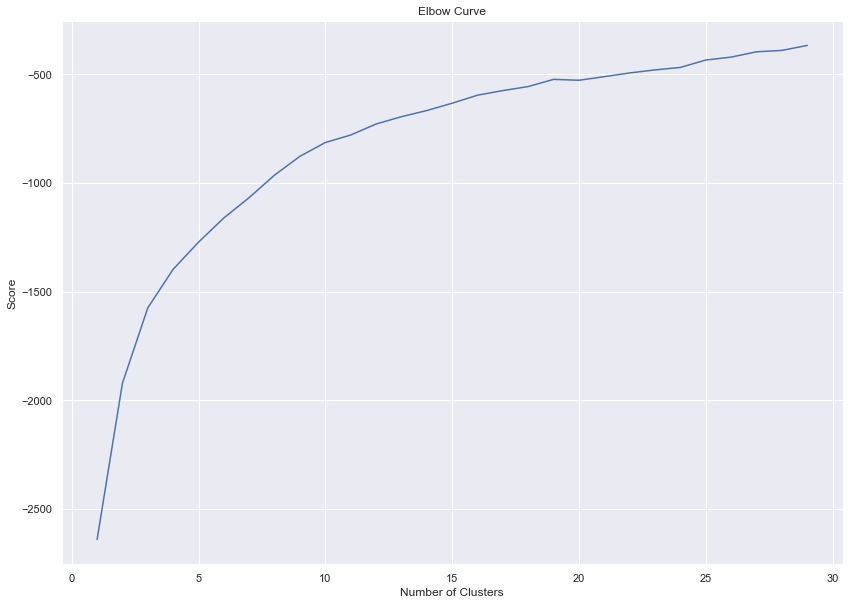

In [56]:
coude_fct(data_pca, 30)

Au vue de la courbe, il semble y avoir 2 "coudes": autour de **3 clusters** et autour de **9 clusters**.

> **Méthode du coefficient de silhouette:**

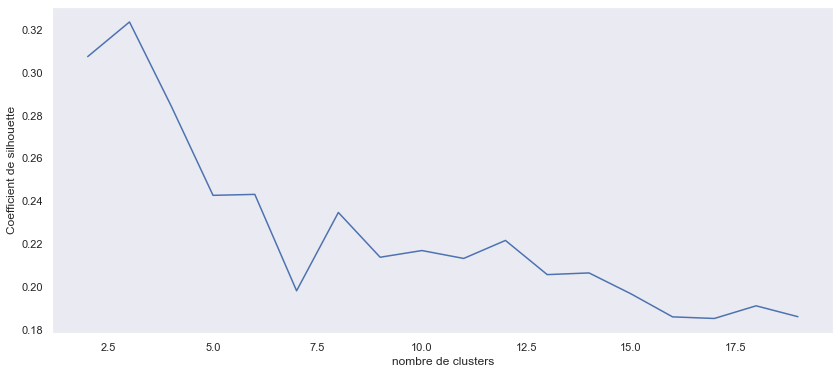

[0.3075160544521182,
 0.323699446669951,
 0.28438050242975915,
 0.24272907086759415,
 0.2431767271894181,
 0.19815490494387172,
 0.23473358907004357,
 0.2138183553520053,
 0.21694829529494883,
 0.213259414591717,
 0.22166737675841955,
 0.20570619257239028,
 0.20649617604429413,
 0.19678013816758688,
 0.18597358615514797,
 0.18522243381234385,
 0.19113557316000193,
 0.18605133647149688]

In [57]:
coeff_silhouette(data_pca, n=20)

La méthode du coefficient de silhouette confirme notre première observation et permet de la préciser, on choisit de s'arréter sur **3 clusters** pour la réalisation du K-Means.

In [58]:
# On génère notre modèle K-Means
# L'algorithme va tourner 100 fois (n_init) et donner le meilleur résultat:
kmeans = KMeans(init='random', n_clusters=3, n_init=100, random_state=42)

# On applique les données sur le modèle
kmeans.fit(data_pca)

# On détermine à quel cluster appartient chaque individus
clusters =  kmeans.predict(data_pca)

In [59]:
# On ajoute les numéros de cluster à notre jeu de données
data_pca_clustered = data_pca
data_pca_clustered["Cluster"] = clusters

data_pca_clustered.head()

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Afghanistan,-3.581028,0.617696,0.058843,1.361179,0.025481,-0.586035,-0.275675,2
Afrique du Sud,1.071967,1.142673,-0.329968,1.607636,-0.479650,0.176023,-0.076617,0
Albanie,0.000072,-0.687218,-0.204558,-0.103313,-0.394445,0.682023,0.036434,0
Algérie,-0.992953,0.449818,1.046942,0.049814,-0.322024,-0.570151,-0.692878,2
Allemagne,3.480799,1.005456,-0.618312,0.565262,0.851783,-0.223779,1.288079,0


Un cluster a été attribué à chacun de nos individus

In [60]:
# on récupère les centroides (individus moyen de chaque groupe)
centroides = kmeans.cluster_centers_

In [61]:
# on passe notre df en array pour la fonction suivante
data_pca_clustered_ar = data_pca_clustered.to_numpy()

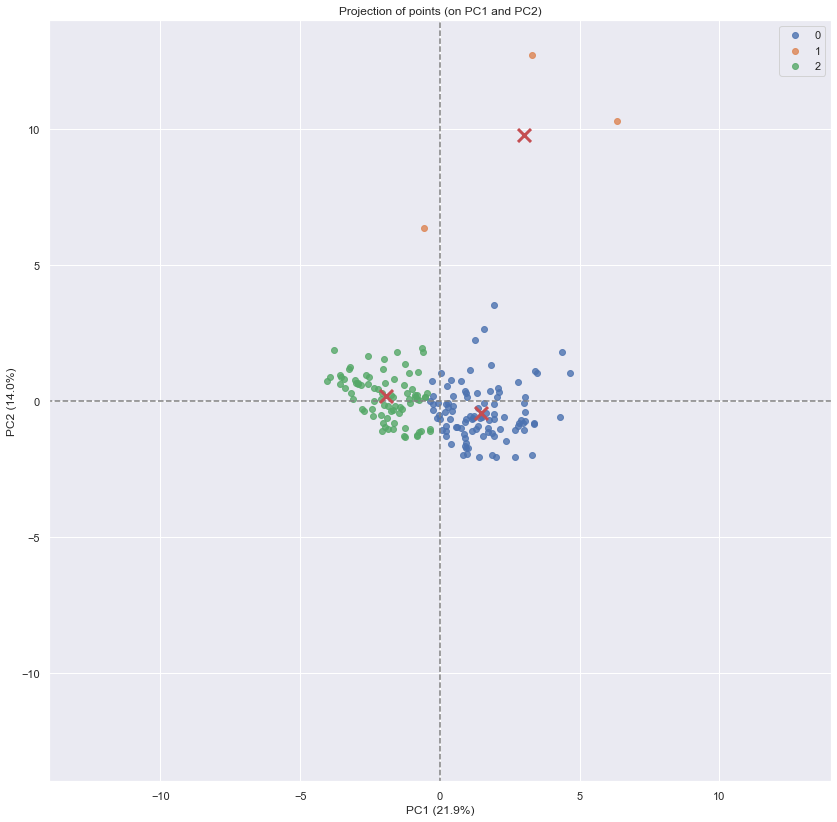

In [62]:
display_factorial_planes(data_pca_clustered_ar, 7, pca, [(0,1)], illustrative_var = clusters, alpha = 0.8)
plt.scatter(centroides[:, 0], centroides[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)

Sur le premier plan factoriel on distingue bien nos 3 clusters avec des centroides bien distincts.

Cela était "attendu" mais nos 3 "outliers" forment un groupe (1) à elles seules. La Chine, l'Inde et les USA du fait de la taille de leur population et de leur puissance économique représentent des superpuissances à part entière. De notre point de vue leur capacité à produire pratiquement l'entièreté de leurs besoins est quelque peu rédhibitoire et n'en fait pas de bons candidats malgré le potentiel de leur marché.

Nous gardons tout de même la Chine dans un coin de notre tête du fait du potentiel que représente ce marché.

In [63]:
# combien de pays par cluster:
data_pca_clustered["Cluster"].value_counts()

0    99
2    80
1     3
Name: Cluster, dtype: int64

On peut étuider les centroides, individus moyens, de nos 2 autres groupes afin de comprendre ce qui les sépare:

In [64]:
# on passe nos centroides en dataframe
centroides_df = pd.DataFrame(centroides, columns=data_pca.columns)
centroides_df["Cluster"] = centroides_df.index
centroides_df

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
0,1.454352,-0.431090,0.132595,-0.004770,-0.247218,0.035169,-0.002165,0
1,3.017406,9.775175,-2.938552,-1.402750,0.484958,-1.154109,-0.558109,1
2,-1.912914,0.166905,-0.053891,0.058506,0.287747,-0.000243,0.023609,2


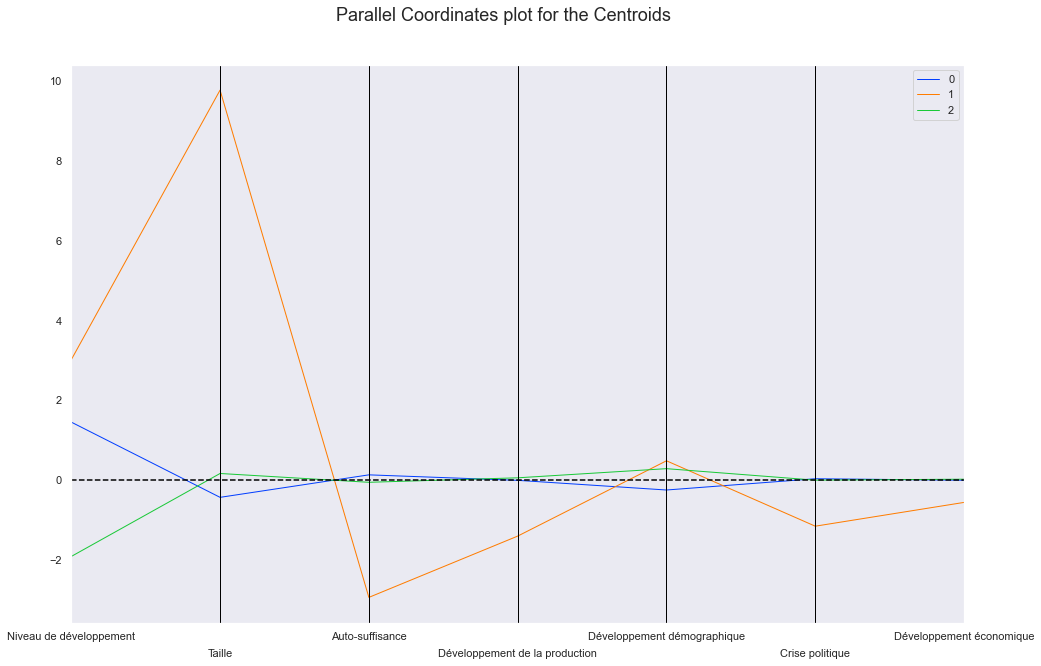

In [65]:
display_parallel_coordinates_centroids(centroides_df, lw=1)
plt.axhline(y=0, color='black', linestyle='dashed')

On constate que c'est principalement le niveau de développement qui différencie ces groupes.

Du fait de nos beosins nous allons principalement étudier le groupe 0, appelons-le groupe "Développés" , en effectuant de nouvelles clusterisation sur lui, afin de trouver des pays se rapprochant le plus possible de notre cible idéale.

> **Étude groupe "Développés":**

In [66]:
gd = data_pca_clustered[data_pca_clustered["Cluster"]==0]
gd = gd.drop(columns="Cluster")

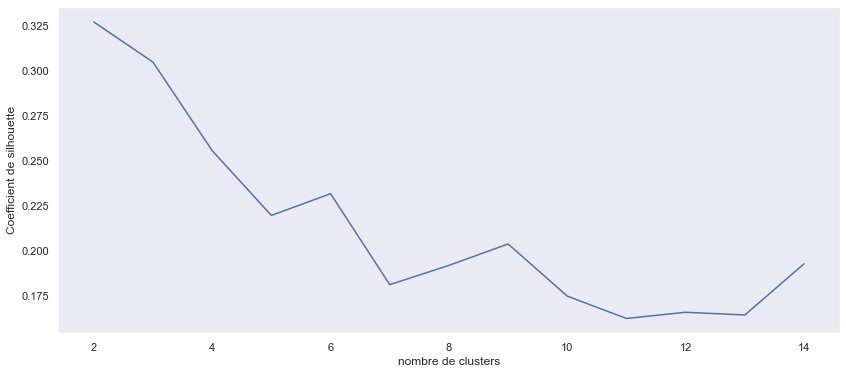

[0.3274531901570301,
 0.3050921939785362,
 0.2558660081036262,
 0.21985776702231175,
 0.23193344344903633,
 0.1813449540238116,
 0.1920556601250724,
 0.20397486215803806,
 0.17496400069229695,
 0.1625330825200281,
 0.16599638953636506,
 0.16447186537636518,
 0.19293213420999542]

In [67]:
coeff_silhouette(gd, n=15)

0    77
1    22
Name: Cluster, dtype: int64


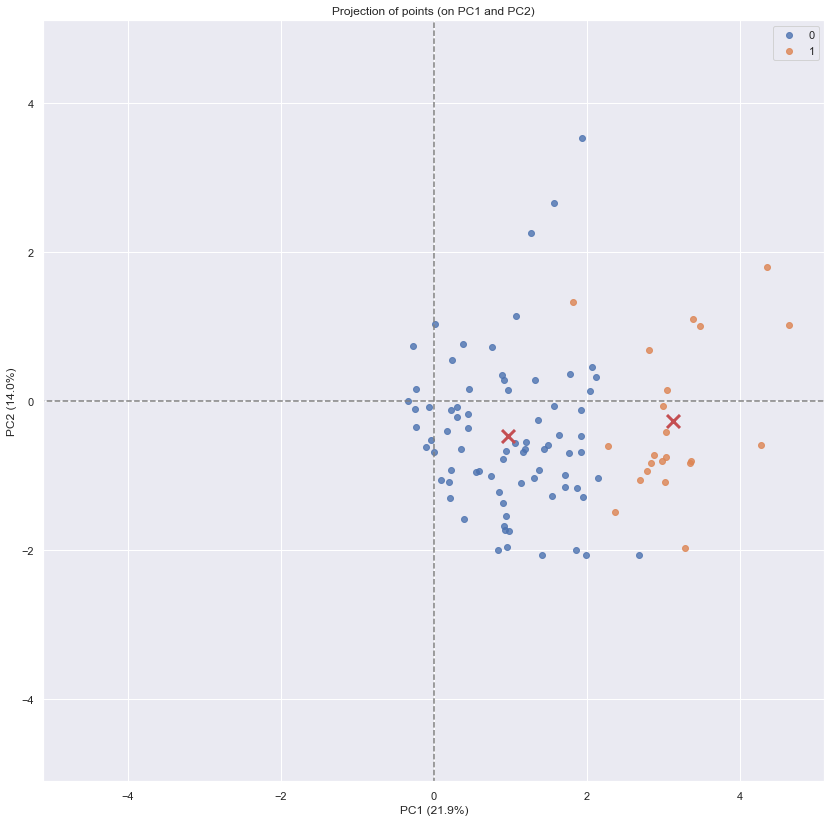

In [70]:
# on procède à un nouveau K-Means sur les données isolées:
kmeans = KMeans(init='random', n_clusters=2, n_init=100, random_state=42)
kmeans.fit(gd)
clusters_gd =  kmeans.predict(gd)

# On ajoute les numéro de cluster à notre jeu de données:
gd_clustered = gd
gd_clustered["Cluster"] = clusters_gd

# gestion des centroides:
centroides_gd = kmeans.cluster_centers_

gd_clustered_ar = gd_clustered.to_numpy()
display_factorial_planes(gd_clustered_ar, 10, pca, [(0,1)], illustrative_var = clusters_gd, alpha = 0.8)
plt.scatter(centroides_gd[:, 0], centroides_gd[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)

print(gd_clustered["Cluster"].value_counts())

In [71]:
# on passe nos centroides en dataframe
centroides_df = pd.DataFrame(centroides_gd, columns=gd.columns)
centroides_df["Cluster"] = centroides_df.index
centroides_df

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
0,0.976381,-0.477103,0.060316,-0.171981,-0.706193,0.021474,-0.197291,0
1,3.127253,-0.270044,0.385572,0.580469,1.359192,0.083101,0.680776,1


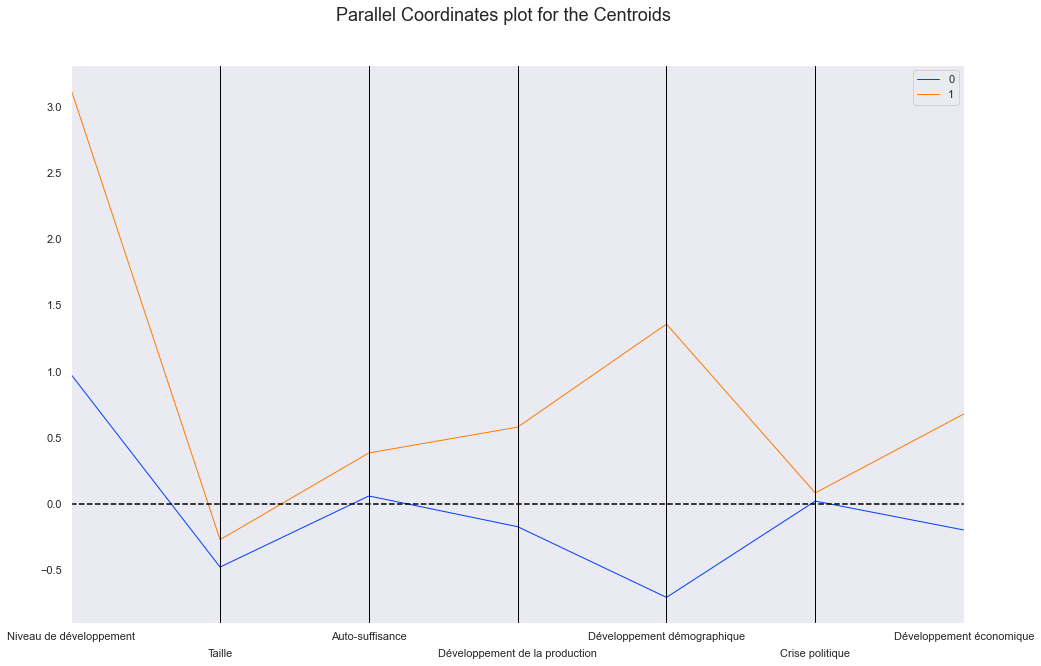

In [72]:
display_parallel_coordinates_centroids(centroides_df, lw=1)
plt.axhline(y=0, color='black', linestyle='dashed')

Le groupe 1 est intéressant sur plusieurs points mais son niveau d'auto-suffisance et de développement de production sont inquiétants.

Le groupe 0 présente des caractéristiques similaire mais plus faibles, partout. Du fait d'un niveau de production plus faible il reste tout de même intéressant.

Essayons d'affiner encore notre recherche:

> **Groupe "Développés" - Sous-cluster 0:** 

In [73]:
gdsc0 = gd_clustered[gd_clustered["Cluster"]==0]
gdsc0 = gdsc0.drop(columns="Cluster")

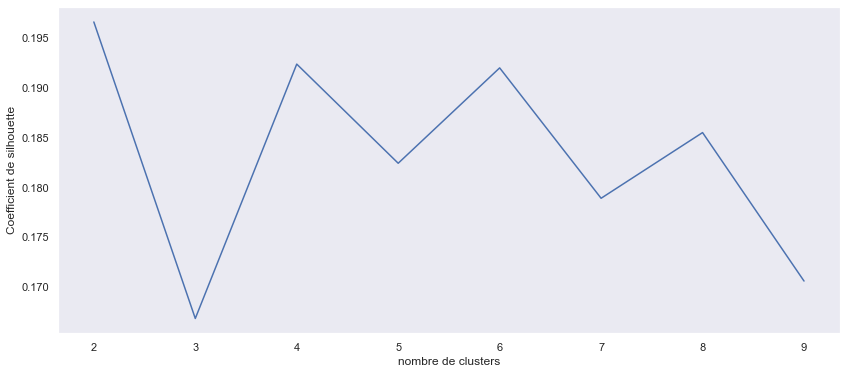

[0.19660702622815213,
 0.1668684326115477,
 0.19238083987700197,
 0.18243681635085374,
 0.19200083371248486,
 0.17892444683972378,
 0.18551248883758892,
 0.17062321869706532]

In [74]:
coeff_silhouette(gdsc0, n=10)

Les scores pour 2, 4 et 6 clusters sont très proches. On va ici "forcer" la détermination de 6 clusters afin d'affiner au mieux notre recherche:

In [76]:
# on procède à un nouveau K-Means sur les données isolées:
kmeans = KMeans(init='random', n_clusters=6, n_init=100, random_state=42)
kmeans.fit(gdsc0)
clusters_gdsc0 =  kmeans.predict(gdsc0)

# On ajoute les numéro de cluster à notre jeu de données:
gdsc0_clustered = gdsc0
gdsc0_clustered["Cluster"] = clusters_gdsc0

# gestion des centroides:
centroides_gdsc0 = kmeans.cluster_centers_

# on passe nos centroides en dataframe
centroides_df = pd.DataFrame(centroides_gdsc0, columns=gd.columns)
centroides_df["Cluster"] = centroides_df.index
centroides_df

print(gdsc0_clustered["Cluster"].value_counts())

1    25
5    17
2    15
0    11
4     5
3     4
Name: Cluster, dtype: int64


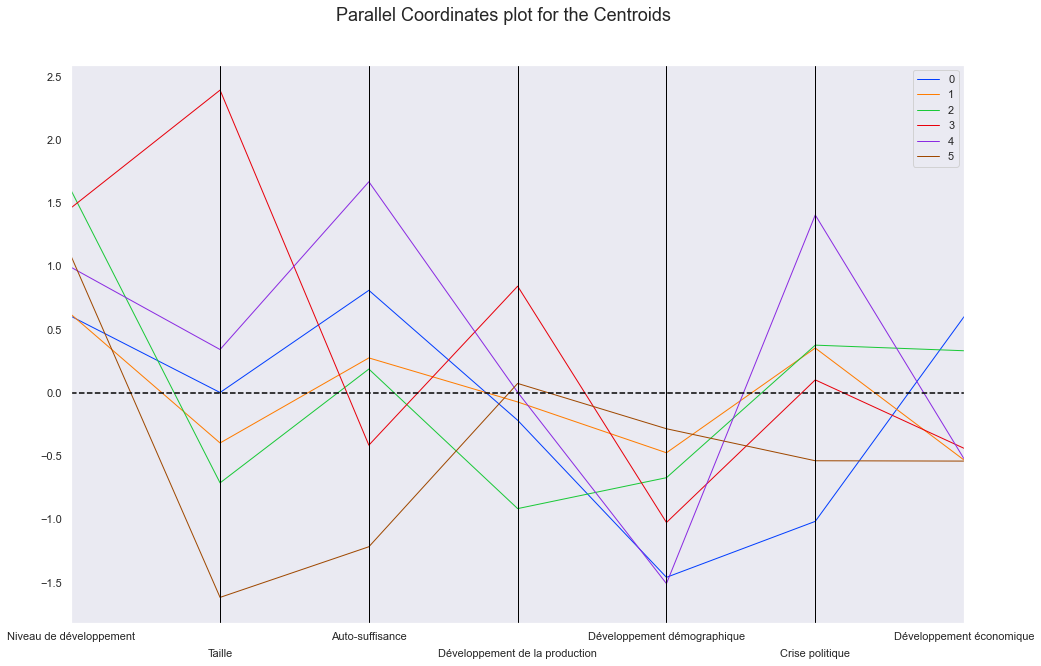

In [77]:
display_parallel_coordinates_centroids(centroides_df, lw=1)
plt.axhline(y=0, color='black', linestyle='dashed')

Ici on retient principalement les groupes **3** et **5** (dans un moindre mesure). Le **groupe 3** est composé de pays représentant des marchés potentiels très importants qui malgré leurs capacités de production ont encore besoin d'apports extérieurs. Le **groupe 5** est lui composé de pays très dépendants d'une production extérieure mais la taille moindre de leur marché est un facteur à prendre en compte.

In [78]:
big_market1 = gdsc0[gdsc0["Cluster"]==3]
big_market1

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Afrique du Sud,1.071967,1.142673,-0.329968,1.607636,-0.479650,0.176023,-0.076617,3
Brésil,1.933333,3.525479,-0.370634,-0.864694,-0.949789,0.546672,-2.066021,3
Fédération de Russie,1.270512,2.250266,0.175538,-0.032411,-1.776451,-0.336168,-0.053595,3
Mexique,1.577048,2.649782,-1.128074,2.660401,-0.891664,0.023202,0.442644,3


In [89]:
gdsc0_2 = gdsc0[gdsc0["Cluster"]==5]
gdsc0_2

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Antigua-et-Barbuda,0.843241,-2.009015,-1.765400,-0.403639,-0.657688,-0.543793,-0.550425,5
Bahamas,2.682751,-2.066439,-1.728623,-0.309889,0.001149,0.627773,-1.334987,5
Bahreïn,0.227769,-0.927213,-1.167652,0.628969,0.536004,-0.345361,-0.416085,5
Cabo Verde,0.394954,-1.593973,-1.417215,-0.300145,0.471782,-0.484305,-0.122530,5
Cuba,1.548087,-1.284619,-1.933910,0.080311,-0.715937,-0.001412,0.884392,5
Dominique,1.859157,-1.997523,-1.006527,-0.328150,-0.297307,-0.903572,-1.179729,5
Grenade,0.925070,-1.732557,-0.971379,-0.237585,-0.160336,-0.422286,-0.934884,5
Koweït,1.304624,-1.030465,-0.655131,0.828457,0.082329,-0.930902,-0.374561,5
Macédoine du Nord,0.207200,-1.301407,-0.708424,-0.479286,-0.950350,-1.192427,0.273241,5


Le groupe 5 comporte beaucoup plus d'individus (17) et mériterait surement d'être partitionner à nouveau:

In [87]:
gdsc0_2 = gdsc0_2.drop(columns="Cluster")

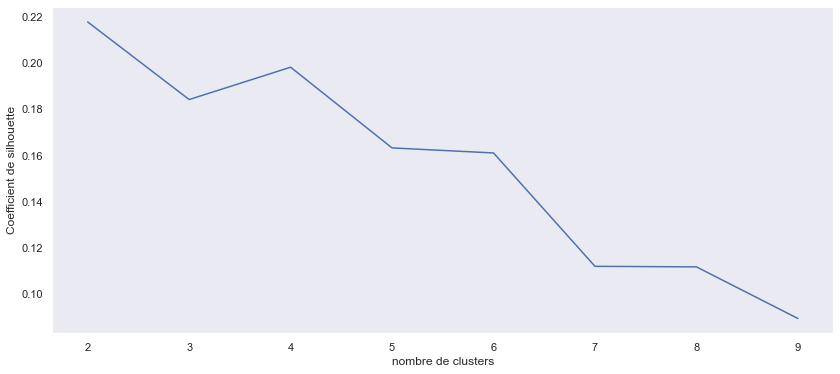

[0.21796096548679414,
 0.18427859070016606,
 0.19831483025288144,
 0.163272671014035,
 0.16108937174700194,
 0.11186509200821862,
 0.11162597208763965,
 0.08922275138121342]

In [90]:
coeff_silhouette(gdsc0_2, n=10)

On va ici "forcer" 4 clusters. Nous verrons que cela nous permet d'isoler 2 pays assez différents des autres sur certaines caractéristiques.

In [92]:
# on procède à un nouveau K-Means sur les données isolées:
kmeans = KMeans(init='random', n_clusters=4, n_init=100, random_state=42)
kmeans.fit(gdsc0_2)
clusters_gdsc0_2 =  kmeans.predict(gdsc0_2)

# On ajoute les numéro de cluster à notre jeu de données:
gdsc0_2_clustered = gdsc0_2
gdsc0_2_clustered["Cluster"] = clusters_gdsc0_2

# gestion des centroides:
centroides_gdsc0_2 = kmeans.cluster_centers_

# on passe nos centroides en dataframe
centroides_df = pd.DataFrame(centroides_gdsc0_2, columns=gd.columns)
centroides_df["Cluster"] = centroides_df.index
centroides_df

print(gdsc0_2_clustered["Cluster"].value_counts())

2    8
1    7
0    1
3    1
Name: Cluster, dtype: int64


C:\Users\MSI\AppData\Local\Temp\ipykernel_14884\3602237760.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdsc0_2_clustered["Cluster"] = clusters_gdsc0_2


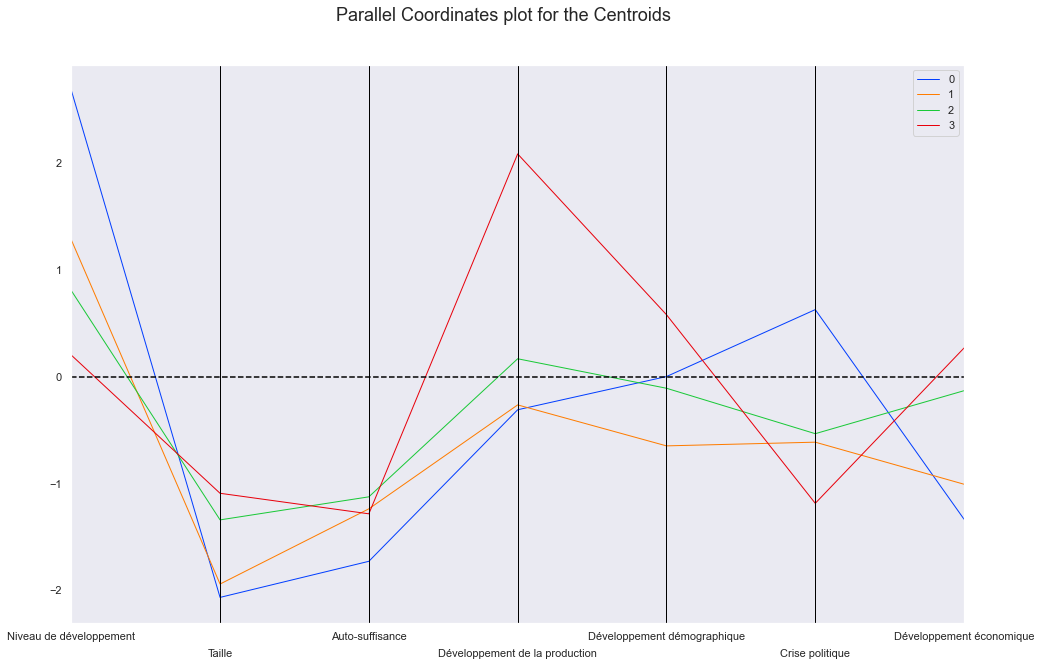

In [93]:
display_parallel_coordinates_centroids(centroides_df, lw=1)
plt.axhline(y=0, color='black', linestyle='dashed')

Le groupes 0, Bahamas présentent des caractéristiques d'évolution politique et économique quelques peu inquiétantes.

Nous allons retenir ici les groupes 1 et 2. Nous mettons aussi de côté le groupe 3, Oman, car malgré un score fort en "Developpement de la production" le pays présente des caractéristiques très intéressantes:

In [155]:
oman = gdsc0_2_clustered[gdsc0_2_clustered["Cluster"]==3]
oman

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Oman,0.202076,-1.091832,-1.284043,2.085296,0.580254,-1.18567,0.268708,3


In [98]:
vsmall_market = gdsc0_2_clustered[gdsc0_2_clustered["Cluster"]==1]
vsmall_market

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Antigua-et-Barbuda,0.843241,-2.009015,-1.765400,-0.403639,-0.657688,-0.543793,-0.550425,1
Dominique,1.859157,-1.997523,-1.006527,-0.328150,-0.297307,-0.903572,-1.179729,1
Grenade,0.925070,-1.732557,-0.971379,-0.237585,-0.160336,-0.422286,-0.934884,1
Saint-Kitts-et-Nevis,1.411736,-2.067930,-1.246651,-0.318019,-1.176241,-1.304020,-0.867361,1
Saint-Vincent-et-les Grenadines,1.990618,-2.066916,-1.325587,-0.183646,-0.973394,-0.287828,-0.747988,1
Sainte-Lucie,0.988107,-1.747181,-1.168989,-0.442124,-0.238277,0.081071,-1.350771,1
Samoa,0.954756,-1.968874,-1.176827,0.062578,-1.032367,-0.912424,-1.418599,1


In [99]:
small_market1 = gdsc0_2_clustered[gdsc0_2_clustered["Cluster"]==2]
small_market1

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Bahreïn,0.227769,-0.927213,-1.167652,0.628969,0.536004,-0.345361,-0.416085,2
Cabo Verde,0.394954,-1.593973,-1.417215,-0.300145,0.471782,-0.484305,-0.122530,2
Cuba,1.548087,-1.284619,-1.933910,0.080311,-0.715937,-0.001412,0.884392,2
Koweït,1.304624,-1.030465,-0.655131,0.828457,0.082329,-0.930902,-0.374561,2
Macédoine du Nord,0.207200,-1.301407,-0.708424,-0.479286,-0.950350,-1.192427,0.273241,2
Nouvelle-Calédonie,0.911769,-1.368339,-0.966706,0.156307,-0.065722,-0.190428,0.122168,2
Polynésie française,0.940210,-1.541039,-1.115589,0.359455,-0.583642,-0.316203,-0.517623,2
Seychelles,0.914931,-1.679310,-1.035167,0.066529,0.358518,-0.809069,-0.899375,2


> **Groupe "Développés" - Sous-cluster 1:** 

In [100]:
gdsc1 = gd_clustered[gd_clustered["Cluster"]==1]
gdsc1 = gdsc1.drop(columns="Cluster")

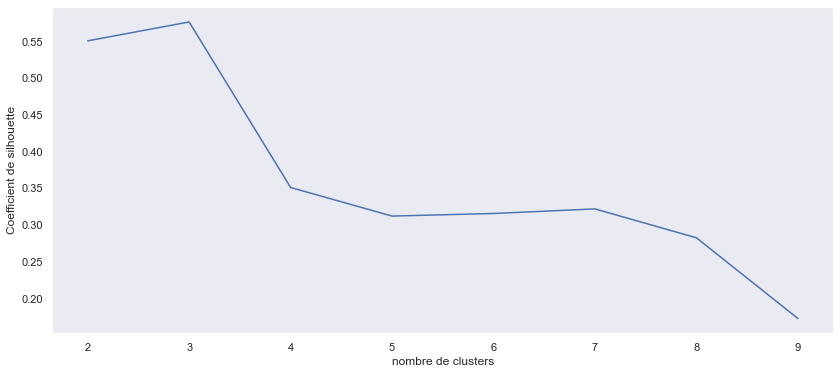

[0.5509887151156128,
 0.5766797767157699,
 0.35118810382874693,
 0.3122313961164677,
 0.31576334980013226,
 0.32198745213361274,
 0.2826449229391655,
 0.1727374120008142]

In [101]:
coeff_silhouette(gdsc1, n=10)

In [103]:
# on procède à un nouveau K-Means sur les données isolées:
kmeans = KMeans(init='random', n_clusters=3, n_init=100, random_state=42)
kmeans.fit(gdsc1)
clusters_gdsc1 =  kmeans.predict(gdsc1)

# On ajoute les numéro de cluster à notre jeu de données:
gdsc1_clustered = gdsc1
gdsc1_clustered["Cluster"] = clusters_gdsc1

# gestion des centroides:
centroides_gdsc1 = kmeans.cluster_centers_

# on passe nos centroides en dataframe
centroides_df = pd.DataFrame(centroides_gdsc1, columns=gd.columns)
centroides_df["Cluster"] = centroides_df.index
centroides_df

print(gdsc1_clustered["Cluster"].value_counts())

2    19
0     2
1     1
Name: Cluster, dtype: int64


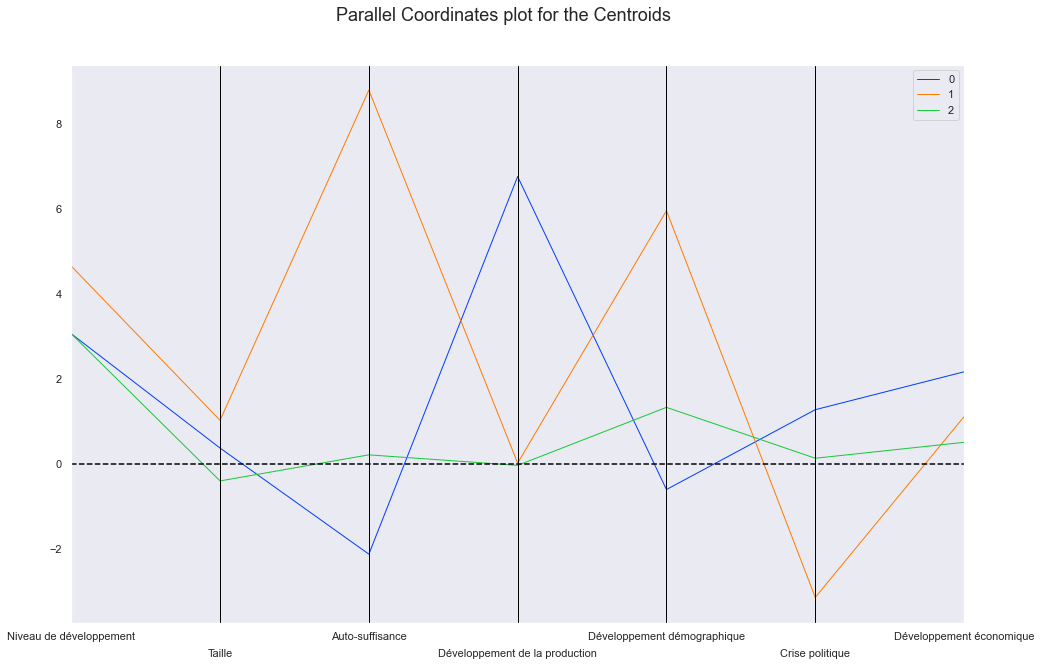

In [104]:
display_parallel_coordinates_centroids(centroides_df, lw=1)
plt.axhline(y=0, color='black', linestyle='dashed')

Ici le **groupe 1** n'est composé que des Pays-Bas, un pays avec une politique particulière puisque auto-suffisant mais aussi grand importateur. On retient ce groupe qui pourra faire l'objet d'une étude approfondie plus tard.

Le **groupe 0**, composé de l'Arabie Saoudite et de Hong-Kong est aussi un groupe intéressant du fait de sa grande dépendance extérieure, un peu à l'image de notre groupe "Small Market".

In [105]:
pays_bas = gdsc1[gdsc1["Cluster"]==1]
pays_bas

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Pays-Bas,4.645914,1.020187,8.784938,0.013381,5.949837,-3.144065,1.105857,1


In [106]:
as_hk = gdsc1[gdsc1["Cluster"]==0]
as_hk

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Arabie saoudite,1.825336,1.330342,-0.669240,4.749955,-0.163489,-0.901848,1.448992,0
Chine - RAS de Hong-Kong,4.284754,-0.595066,-3.585809,8.755211,-1.051949,3.441153,2.872800,0


Le groupe 2 comporte beaucoup plus d'individus (19) et mériterait surement d'être partitionner à nouveau:

In [107]:
gdsc1_2 = gdsc1_clustered[gdsc1_clustered["Cluster"]==2]
gdsc1_2 = gdsc1_2.drop(columns="Cluster")

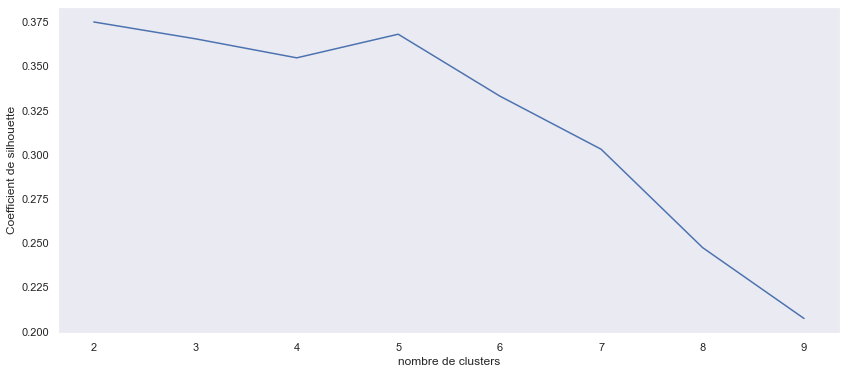

[0.37513546893214883,
 0.3656207208212057,
 0.3548332256395458,
 0.36820311497037816,
 0.33324411247265384,
 0.30311419486883456,
 0.24746704934896024,
 0.20734226003030487]

In [108]:
coeff_silhouette(gdsc1_2, n=10)

In [111]:
# on procède à un nouveau K-Means sur les données isolées:
kmeans = KMeans(init='random', n_clusters=5, n_init=100, random_state=42)
kmeans.fit(gdsc1_2)
clusters_gdsc1_2 =  kmeans.predict(gdsc1_2)

# On ajoute les numéro de cluster à notre jeu de données:
gdsc1_2_clustered = gdsc1_2
gdsc1_2_clustered["Cluster"] = clusters_gdsc1_2

# gestion des centroides:
centroides_gdsc1_2 = kmeans.cluster_centers_

# on passe nos centroides en dataframe
centroides_df = pd.DataFrame(centroides_gdsc1_2, columns=gd.columns)
centroides_df["Cluster"] = centroides_df.index
centroides_df

print(gdsc1_2_clustered["Cluster"].value_counts())

1    11
0     4
3     2
4     1
2     1
Name: Cluster, dtype: int64


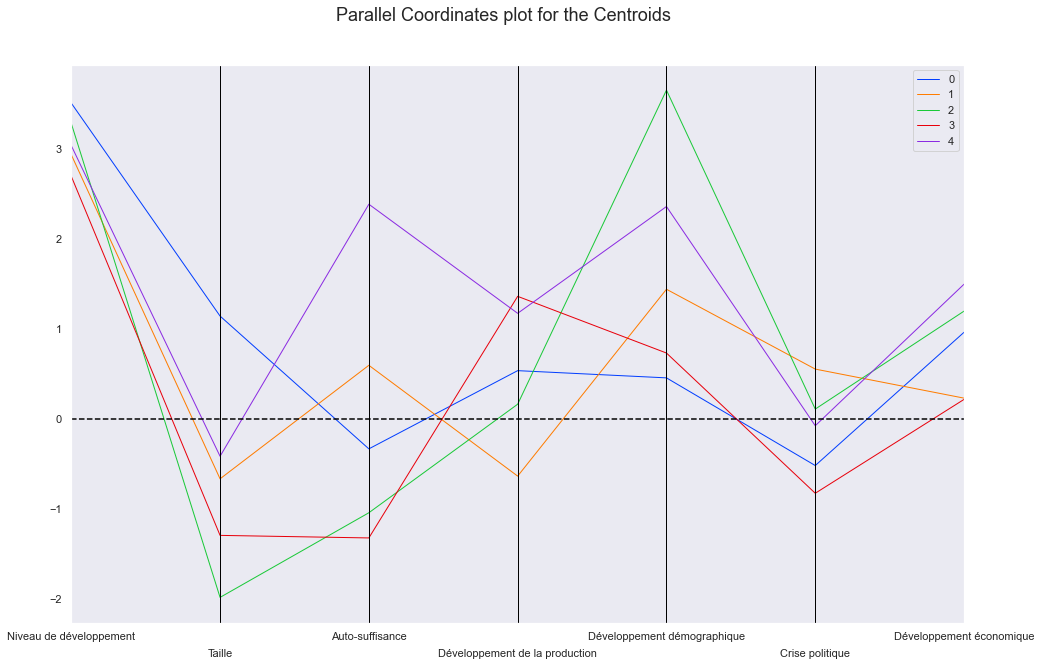

In [112]:
display_parallel_coordinates_centroids(centroides_df, lw=1)
plt.axhline(y=0, color='black', linestyle='dashed')

Ici, deux groupes se distinguent: le **groupe 3** composé du Qatar et des EAU, qui présente certaines ressemblence avec nos groupes "Small Market" et le **groupe 0** composé des 3 leaders économique de l'Union Européenne (France, Allemagne, UK) et du Japon. A l'image du groupe "Big Market" ces pays produisent une bonne partie de leurs besoins mais reste des marchés avec un potentiel très important.

In [113]:
small_market2 = gdsc1_2[gdsc1_2["Cluster"]==3]
small_market2

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Qatar,2.372522,-1.492386,-1.180288,0.654117,1.133733,0.219830,-0.389048,3
Émirats arabes unis,3.020893,-1.090259,-1.459181,2.071719,0.333215,-1.866794,0.826509,3


In [114]:
big_market2 = gdsc1_2[gdsc1_2["Cluster"]==0]
big_market2

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Allemagne,3.480799,1.005456,-0.618312,0.565262,0.851783,-0.223779,1.288079,0
France,2.809642,0.676598,-0.211228,0.124183,0.039272,-0.976038,1.004394,0
Japon,4.354707,1.796345,-0.678068,0.952923,-0.025940,-0.855164,1.180215,0
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,3.389436,1.097103,0.184985,0.508795,0.965570,-0.008418,0.383939,0


***

<center> Nous avons donc identifier 7 groupes de pays susceptibles de nous intéresser.

<center> Utilisons une autre méthode de clusterisation afin de confirmer ou infirmer nos résultats:

***

### Méthode CAH (Classification Ascendante Hierarchique) <a class="anchor" id="section_3_2"></a>

La méthode Classification Ascendante Hierarchique, permet la clusterisation en rapprochant les individus les plus "proches" 2 à 2 jusqu'à arriver à un groupe final qui est en réalité le jeu de données entier. 

La réalisation d'un dendrogramme permet de visualiser cette classification:

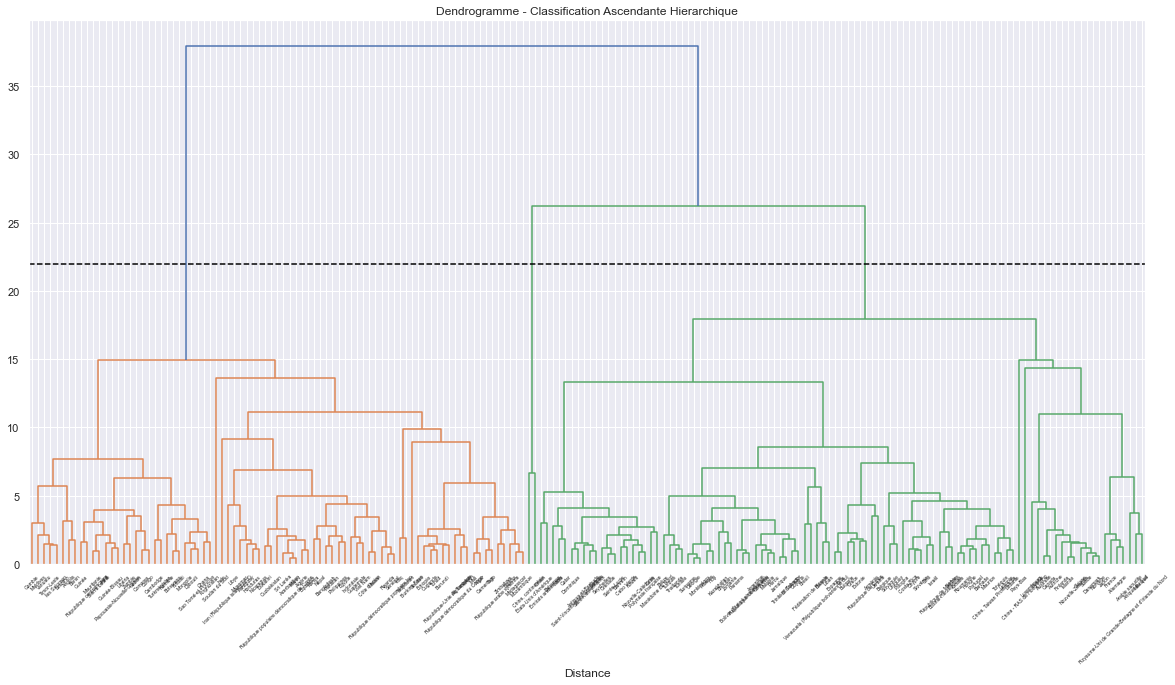

In [115]:
# rappel: on utilise la méthode de ward pour rapprocher nos individus:
dendrogram_fct (data_pca, figsize=(20,10), orientation="top", p=182, fontsize=5)
# on peut aussi ajouter une ligne qui coupera notre dendrogramme
# on peut afficher une ligne au niveau des 3 clusters identifiés précédemment:
plt.axhline(y=22, color='black', linestyle='dashed')

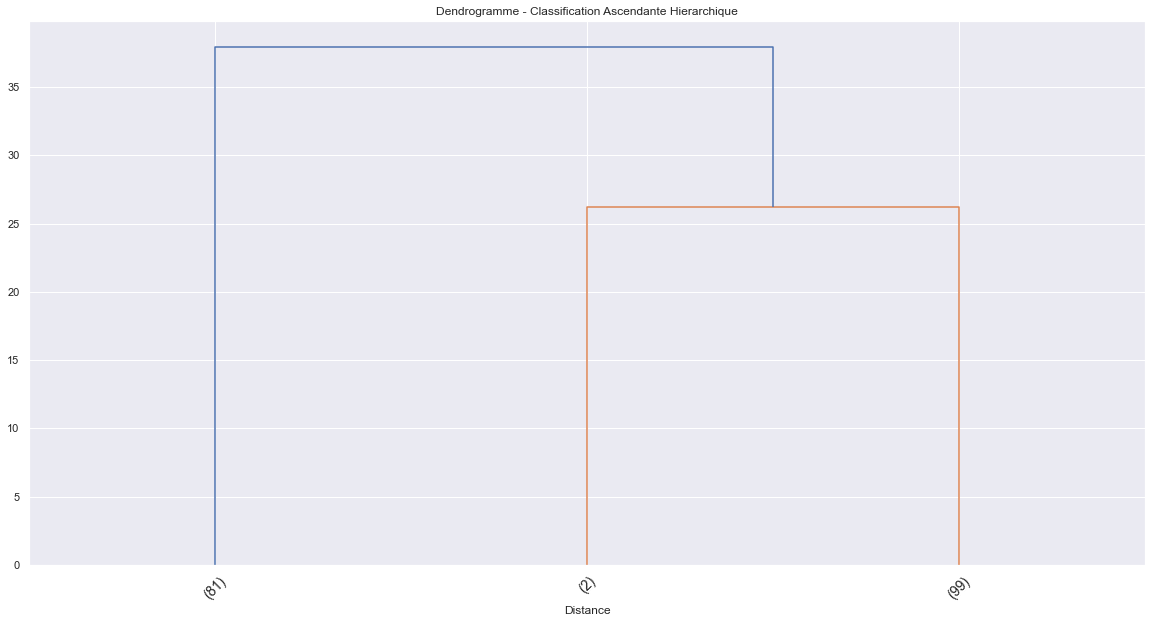

In [116]:
dendrogram_fct (data_pca, figsize=(20,10), orientation="top", p=3, fontsize=14)

On remarque que l'on retrouve une répartition très proche de celle obtenue via la méthode K-Means.

Comme précédemment, étudions les groupes au travers des individus moyens de chacun d'entre eux:

In [117]:
# On crée notre modèle.
# On choisit la méthode de Ward comme méthode de rapprochement:
hiercluster = AgglomerativeClustering(affinity='euclidean', linkage='ward', compute_full_tree=True) 

In [118]:
hiercluster.set_params(n_clusters=3) # on cherche 3 clusters comme déterminé précédemment
clusters_cah = hiercluster.fit_predict(data_pca) 
np.bincount(clusters_cah) # compte le nombre d'individus dans chaque clusters

array([99, 81,  2], dtype=int64)

In [119]:
# on ajoute nos clusters à nos données:
data_pca_clustered = pd.DataFrame(data_pca, columns=data_pca.columns, index=data_pca.index)
data_pca_clustered["Cluster"] = clusters_cah

data_pca_clustered.head()

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Afghanistan,-3.581028,0.617696,0.058843,1.361179,0.025481,-0.586035,-0.275675,1
Afrique du Sud,1.071967,1.142673,-0.329968,1.607636,-0.479650,0.176023,-0.076617,0
Albanie,0.000072,-0.687218,-0.204558,-0.103313,-0.394445,0.682023,0.036434,0
Algérie,-0.992953,0.449818,1.046942,0.049814,-0.322024,-0.570151,-0.692878,1
Allemagne,3.480799,1.005456,-0.618312,0.565262,0.851783,-0.223779,1.288079,0


In [120]:
data_pca_clustered["Cluster"].value_counts()

0    99
1    81
2     2
Name: Cluster, dtype: int64

In [121]:
c0 = data_pca_clustered[data_pca_clustered["Cluster"]==0]
c1 = data_pca_clustered[data_pca_clustered["Cluster"]==1]
c2 = data_pca_clustered[data_pca_clustered["Cluster"]==2]


c__0 = ({
    "Niveau de développement":[c0["Niveau de développement"].mean()],
    "Taille":[c0["Taille"].mean()],
    "Auto-suffisance":[c0["Auto-suffisance"].mean()],
    "Développement de la production":[c0["Développement de la production"].mean()],
    "Développement démographique":[c0["Développement démographique"].mean()],
    "Crise politique":[c0["Crise politique"].mean()],
    "Développement économique":[c0["Développement économique"].mean()],
    "Cluster":["0"]})

c__1 = ({
    "Niveau de développement":c1["Niveau de développement"].mean(),
    "Taille":c1["Taille"].mean(),
    "Auto-suffisance":c1["Auto-suffisance"].mean(),
    "Développement de la production":c1["Développement de la production"].mean(),
    "Développement démographique":c1["Développement démographique"].mean(),
    "Crise politique":c1["Crise politique"].mean(),
    "Développement économique":c1["Développement économique"].mean(),
    "Cluster":"1"})

c__2 = ({
    "Niveau de développement":c2["Niveau de développement"].mean(),
    "Taille":c2["Taille"].mean(),
    "Auto-suffisance":c2["Auto-suffisance"].mean(),
    "Développement de la production":c2["Développement de la production"].mean(),
    "Développement démographique":c2["Développement démographique"].mean(),
    "Crise politique":c2["Crise politique"].mean(),
    "Développement économique":c2["Développement économique"].mean(),
    "Cluster":"2"})

centr_cah = pd.DataFrame(c__0)
centr_cah = centr_cah.append(c__1, ignore_index=True)
centr_cah = centr_cah.append(c__2, ignore_index=True)

centr_cah

C:\Users\MSI\AppData\Local\Temp\ipykernel_14884\2674378210.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  centr_cah = centr_cah.append(c__1, ignore_index=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_14884\2674378210.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  centr_cah = centr_cah.append(c__2, ignore_index=True)


,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
0,1.454352,-0.431090,0.132595,-0.004770,-0.247218,0.035169,-0.002165,0
1,-1.896165,0.243013,-0.064630,0.039945,0.277028,-0.023536,0.017019,1
2,4.804223,11.496937,-3.945955,-1.381695,1.017692,-0.787647,-0.582067,2


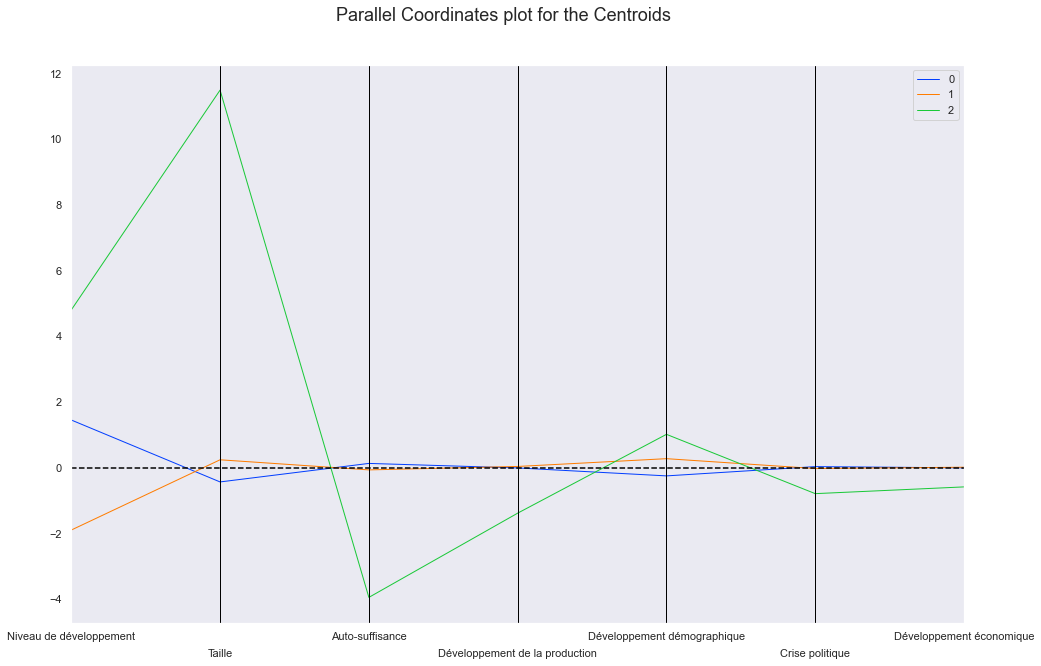

In [122]:
display_parallel_coordinates_centroids(centr_cah, lw=1)
plt.axhline(y=0, color='black', linestyle='dashed')

Au delà d'avoir des groupes se ressemblant en termes de nombre d'individus, les 2 méthodes nous offrent des résultats quasi similaire en ce qui concerne les individus qui composent ces groupes. 

Comme précédemment nous retenons ici le groupe 0, "Pays développés". Étudions la classification au sein de ce groupe:

> **Étude groupe "Développés"**:

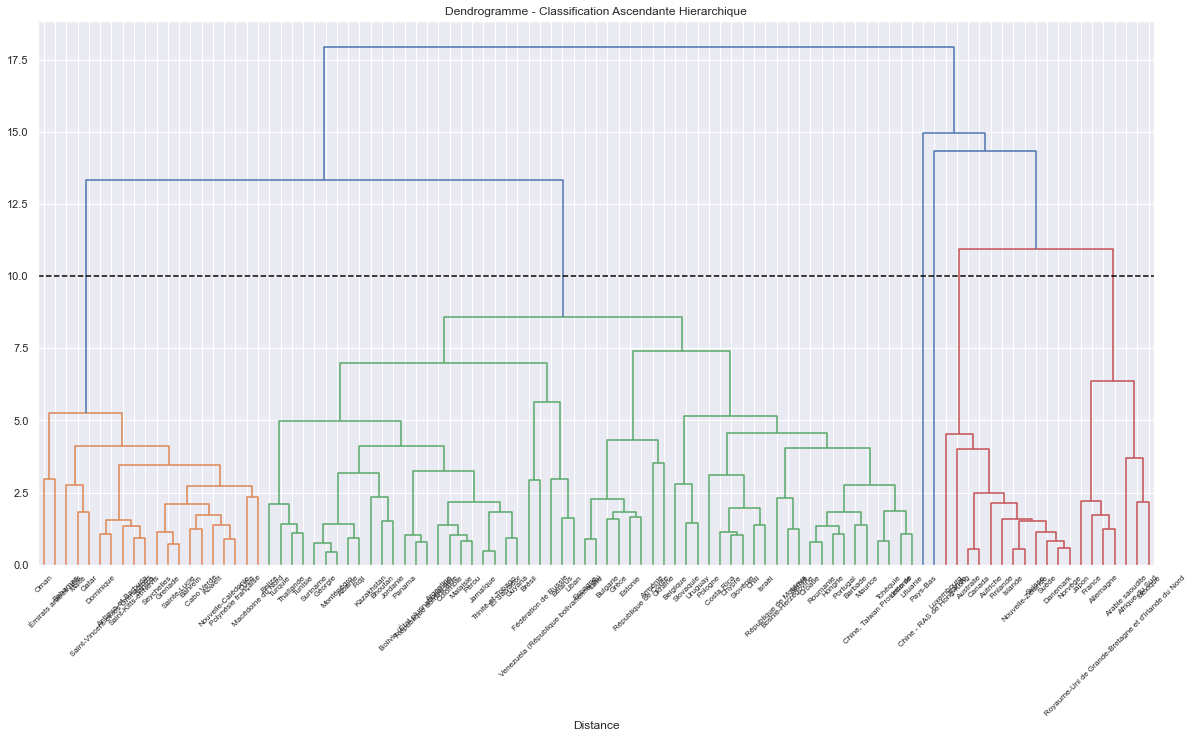

In [123]:
dendrogram_fct (c0, figsize=(20,10), orientation="top", p=99, fontsize=8)
# on pourrait ici découper notre dendrogramm au niveau des 6 clusters afin de les étudier de plus près:
plt.axhline(y=10, color='black', linestyle='dashed')

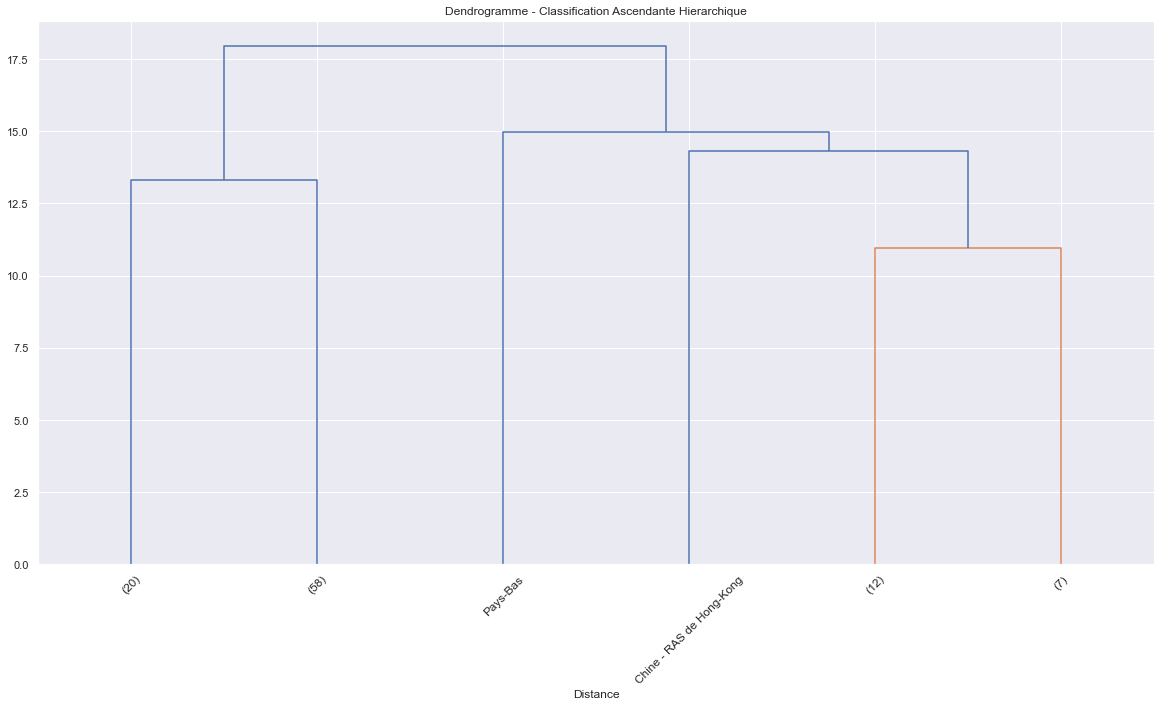

In [124]:
dendrogram_fct (c0, figsize=(20,10), orientation="top", p=6, fontsize=12)

On remarque tout suite, qu'encore une fois, les Pays-Bas et Hong-Kong forment des groupes à part entière. On peut étudier le contenu des 4 autres groupes afin de les comparer aux résultats observés précédemment:

In [125]:
c0 = c0.drop(columns="Cluster")

In [126]:
hiercluster.set_params(n_clusters=6) # on cherche 6 clusters comme déterminé précédemment
clusters_cah = hiercluster.fit_predict(c0) 
np.bincount(clusters_cah) # compte le nombre d'individus dans chaque clusters

array([58,  7, 12,  1, 20,  1], dtype=int64)

In [127]:
# on ajoute nos clusters à nos données:
c0_clustered = pd.DataFrame(c0, columns=c0.columns, index=c0.index)
c0_clustered["Cluster"] = clusters_cah

c0_clustered.head()

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Afrique du Sud,1.071967,1.142673,-0.329968,1.607636,-0.479650,0.176023,-0.076617,1
Albanie,0.000072,-0.687218,-0.204558,-0.103313,-0.394445,0.682023,0.036434,0
Allemagne,3.480799,1.005456,-0.618312,0.565262,0.851783,-0.223779,1.288079,1
Antigua-et-Barbuda,0.843241,-2.009015,-1.765400,-0.403639,-0.657688,-0.543793,-0.550425,4
Arabie saoudite,1.825336,1.330342,-0.669240,4.749955,-0.163489,-0.901848,1.448992,1


In [128]:
c0_clustered["Cluster"].value_counts()

0    58
4    20
2    12
1     7
3     1
5     1
Name: Cluster, dtype: int64

In [129]:
c00 = c0_clustered[c0_clustered["Cluster"]==0]
c01 = c0_clustered[c0_clustered["Cluster"]==1]
c02 = c0_clustered[c0_clustered["Cluster"]==2]
c03 = c0_clustered[c0_clustered["Cluster"]==3]
c04 = c0_clustered[c0_clustered["Cluster"]==4]
c05 = c0_clustered[c0_clustered["Cluster"]==5]

### Comparaison des résultats <a class="anchor" id="section_3_3"></a>

In [130]:
c00

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Albanie,0.000072,-0.687218,-0.204558,-0.103313,-0.394445,0.682023,0.036434,0
Argentine,1.321870,0.277125,0.312619,0.237101,-1.282964,0.033065,-1.374790,0
Arménie,0.090622,-1.061864,-0.444069,0.466964,-2.361363,-2.075748,1.709818,0
Barbade,1.712125,-1.151831,0.386236,-0.955360,-1.207846,-0.440831,-0.714079,0
Belgique,2.844803,-0.831289,-0.384981,-1.890218,1.113005,-0.064340,1.120253,0
Belize,-0.036514,-0.526042,0.654100,-0.523900,-0.491580,-0.887342,-1.278763,0
Bhoutan,-0.101040,-0.621805,-0.028503,-0.361948,0.488321,-0.513568,0.492896,0
Bolivie (État plurinational de),-0.239265,0.158494,0.594482,-0.064753,-0.531283,1.237979,-1.192417,0
Bosnie-Herzégovine,0.302031,-0.088172,0.970349,-0.822499,-1.434683,1.314092,-0.143648,0


> Au sein du sous-groupe 0, on ne retouve aucun pays sélectionné précédemment, si ce n'est le Brésil et la Russie. Il s'agit globalement de pays assez moyen en terme développement et d'auto-suffisance donc peu intéressant pour nous.

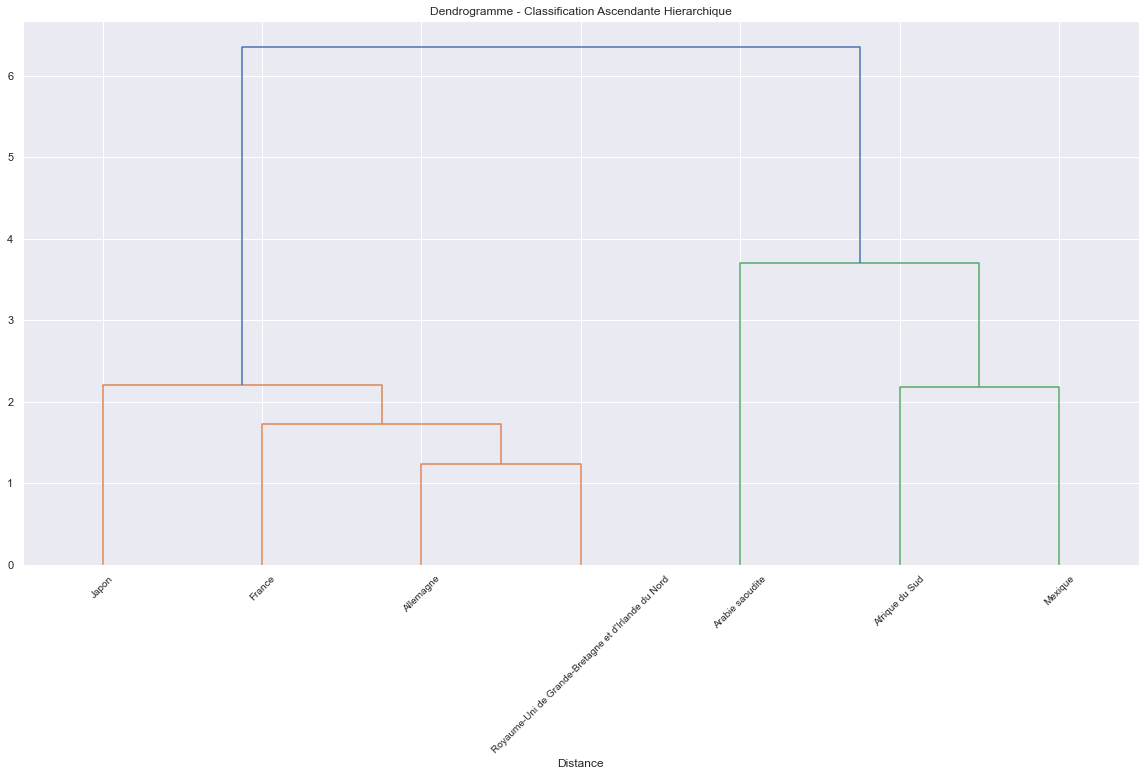

In [131]:
dendrogram_fct (c01, figsize=(20,10), orientation="top", p=58, fontsize=10)

> Le sous-groupe 1 en revanche ressemble beaucoup un sous-groupe identifiés grâce au K-means et regroupent de nombreux individus que nous avions isolés. On y retrouve notamment beaucoup d'individus de nos 2 "Big Market". 
On remarque aussi le rapprochement de l'Arabie Saoudite, initialement isolées aux côtés de Hong-Kong.

In [132]:
big_market1

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Afrique du Sud,1.071967,1.142673,-0.329968,1.607636,-0.479650,0.176023,-0.076617,3
Brésil,1.933333,3.525479,-0.370634,-0.864694,-0.949789,0.546672,-2.066021,3
Fédération de Russie,1.270512,2.250266,0.175538,-0.032411,-1.776451,-0.336168,-0.053595,3
Mexique,1.577048,2.649782,-1.128074,2.660401,-0.891664,0.023202,0.442644,3


In [133]:
big_market2

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Allemagne,3.480799,1.005456,-0.618312,0.565262,0.851783,-0.223779,1.288079,0
France,2.809642,0.676598,-0.211228,0.124183,0.039272,-0.976038,1.004394,0
Japon,4.354707,1.796345,-0.678068,0.952923,-0.025940,-0.855164,1.180215,0
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,3.389436,1.097103,0.184985,0.508795,0.965570,-0.008418,0.383939,0


***

In [134]:
c02

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Australie,2.993773,-0.074776,0.378676,-0.406080,1.362417,1.157625,-0.473540,2
Autriche,2.278409,-0.603291,1.417682,-0.086342,1.016070,-0.337285,0.416954,2
Canada,3.051850,0.149821,-0.003464,-0.295810,1.340021,1.084657,-0.191511,2
Danemark,3.354213,-0.837114,0.930900,-0.762781,1.339028,0.457035,0.647956,2
Finlande,3.036984,-0.761080,0.785453,-1.055421,0.901517,1.243669,0.324155,2
Irlande,3.037018,-0.412904,2.385738,1.174249,2.360162,-0.073690,1.498090,2
Islande,2.703656,-1.059151,0.535412,-0.596003,1.957167,0.546930,-0.255104,2
Luxembourg,3.283470,-1.979877,-1.040077,0.165133,3.652788,0.111198,1.198959,2
Norvège,2.986641,-0.806418,0.842473,-0.779408,1.560318,0.400588,0.297702,2


Ce groupe est composé de pays développés plutôt auto-suffisants, ce qui n'en fait pas de bons candidats pour notre projet.

***

In [135]:
c03

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Chine - RAS de Hong-Kong,4.284754,-0.595066,-3.585809,8.755211,-1.051949,3.441153,2.8728,3


In [136]:
as_hk

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Arabie saoudite,1.825336,1.330342,-0.669240,4.749955,-0.163489,-0.901848,1.448992,0
Chine - RAS de Hong-Kong,4.284754,-0.595066,-3.585809,8.755211,-1.051949,3.441153,2.872800,0


***

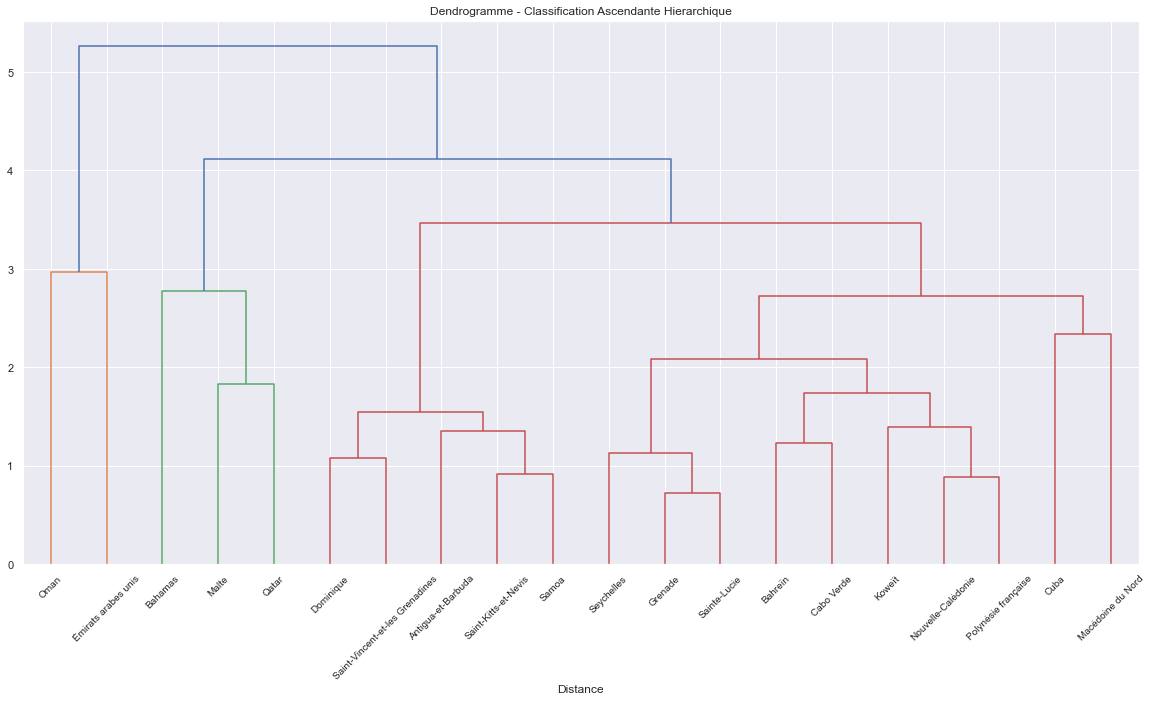

In [137]:
dendrogram_fct (c04, figsize=(20,10), orientation="top", p=58, fontsize=10)

Le sous-groupe 4 ressemble aussi beaucoup un sous-groupe identifiés grâce au K-means et regroupent de nombreux individus que nous avions isolés. On y retrouve en réalité la quasi totalité des individus de nos "Small Market".

In [139]:
vsmall_market

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Antigua-et-Barbuda,0.843241,-2.009015,-1.765400,-0.403639,-0.657688,-0.543793,-0.550425,1
Dominique,1.859157,-1.997523,-1.006527,-0.328150,-0.297307,-0.903572,-1.179729,1
Grenade,0.925070,-1.732557,-0.971379,-0.237585,-0.160336,-0.422286,-0.934884,1
Saint-Kitts-et-Nevis,1.411736,-2.067930,-1.246651,-0.318019,-1.176241,-1.304020,-0.867361,1
Saint-Vincent-et-les Grenadines,1.990618,-2.066916,-1.325587,-0.183646,-0.973394,-0.287828,-0.747988,1
Sainte-Lucie,0.988107,-1.747181,-1.168989,-0.442124,-0.238277,0.081071,-1.350771,1
Samoa,0.954756,-1.968874,-1.176827,0.062578,-1.032367,-0.912424,-1.418599,1


In [138]:
small_market1

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Bahreïn,0.227769,-0.927213,-1.167652,0.628969,0.536004,-0.345361,-0.416085,2
Cabo Verde,0.394954,-1.593973,-1.417215,-0.300145,0.471782,-0.484305,-0.122530,2
Cuba,1.548087,-1.284619,-1.933910,0.080311,-0.715937,-0.001412,0.884392,2
Koweït,1.304624,-1.030465,-0.655131,0.828457,0.082329,-0.930902,-0.374561,2
Macédoine du Nord,0.207200,-1.301407,-0.708424,-0.479286,-0.950350,-1.192427,0.273241,2
Nouvelle-Calédonie,0.911769,-1.368339,-0.966706,0.156307,-0.065722,-0.190428,0.122168,2
Polynésie française,0.940210,-1.541039,-1.115589,0.359455,-0.583642,-0.316203,-0.517623,2
Seychelles,0.914931,-1.679310,-1.035167,0.066529,0.358518,-0.809069,-0.899375,2


In [140]:
small_market2

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Qatar,2.372522,-1.492386,-1.180288,0.654117,1.133733,0.219830,-0.389048,3
Émirats arabes unis,3.020893,-1.090259,-1.459181,2.071719,0.333215,-1.866794,0.826509,3


***

In [141]:
c05

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Pays-Bas,4.645914,1.020187,8.784938,0.013381,5.949837,-3.144065,1.105857,5


In [142]:
pays_bas

,Niveau de développement,Taille,Auto-suffisance,Développement de la production,Développement démographique,Crise politique,Développement économique,Cluster
Pays,,,,,,,,
Pays-Bas,4.645914,1.020187,8.784938,0.013381,5.949837,-3.144065,1.105857,1


***

## IV) Interprétation & Recommandations <a class="anchor" id="chapter4"></a>

Suite aux observations précédentes et en croisant les résultats des différentes méthodes nous pouvons affiner la composition des clusters pré-définis avec la méthode K-Means.

Nous souhaitons aussi les étudier au travers de nos données initiales. Le nombre d'individus ayant été grandement réduit, l'interprétation des valeurs associées à chaque pays est désormais beaucoup plus digeste:

> **Big Market:**

In [144]:
big_market1.index

Index(['Afrique du Sud', 'Brésil', 'Fédération de Russie', 'Mexique'], dtype='object', name='Pays')

In [210]:
bm1 = data[(data.index.isin(["Afrique du Sud"])) |
                      (data.index.isin(["Brésil"])) |
                      (data.index.isin(["Fédération de Russie"])) |
                      (data.index.isin(["Mexique"]))]
bm1

,Population,Evo population (%),Population urbaine (%),Evo population urbaine (%),Disponibilité (tonnes),Disponibilité (kg/habitant),Evo disponibilité (%),Importations (tonnes),Taux importation (%),Evo taux importation,Taux production (%),Evo taux production,PIB,Evo PIB (%),PIB/habitant,Stabilité politique,Evo stabilité politique (%),CPI,Evo CPI
Pays,,,,,,,,,,,,,,,,,,,
Afrique du Sud,58801927.0,4.217577,67.261212,8.059639,2029917.0,37.865119,6.604877,478091.0,17.916718,-4.973859,84.132166,3.798755,3.021412e+05,1.957287,5094.384038,-0.24,-0.10,44.0,-1.0
Brésil,213196304.0,3.063298,87.345356,4.224268,9022582.0,46.403869,6.622160,3119.0,0.052116,0.018502,139.364142,-3.274178,1.444733e+06,-19.544544,6796.844058,-0.42,-0.04,38.0,-2.0
Fédération de Russie,145617329.0,0.350200,73.814202,0.670589,4339080.0,31.695735,5.720474,214218.0,4.702751,-0.204081,99.161181,2.224304,1.483498e+06,16.189966,10165.505967,-0.73,0.22,30.0,1.0
Mexique,125998302.0,3.685903,85.774497,6.485401,3856484.0,35.398202,15.652325,780608.0,19.762261,-0.479181,80.237739,0.427372,1.073439e+06,-0.468639,8325.571218,-0.85,-0.22,31.0,1.0


On étudiant de plus près ce groupe on remarque que le Brésil et la Russie ont des taux d'importation très faible. On ne retient donc ici que le Mexique et l'Afrique du Sud.

In [145]:
big_market2.index

Index(['Allemagne', 'France', 'Japon',
       'Royaume-Uni de Grande-Bretagne et d'Irlande du Nord'],
      dtype='object', name='Pays')

In [2]:
# puisque nous sommes déjà implantés sur la marché français nous ne l'incluons pas dans la version "finale" de nos clusters:
bm2 = data[(data.index.isin(["Allemagne"])) |
           (data.index.isin(["Japon"])) |
           (data.index.isin(["Royaume-Uni de Grande-Bretagne et d'Irlande du Nord"]))]
bm2

NameError: name 'data' is not defined

Tous les pays de ce groupe sont de potentiels bons candidats. 

On peut donc former un groupe "Big Market" additionnant les deux groupes étudiés ici:

In [177]:
big_market = data[(data.index.isin(["Allemagne"])) |
                  (data.index.isin(["Japon"])) |
                  (data.index.isin(["Royaume-Uni de Grande-Bretagne et d'Irlande du Nord"]))|
                  (data.index.isin(["Afrique du Sud"])) |
                  (data.index.isin(["Arabie saoudite"])) |
                  (data.index.isin(["Mexique"]))]
big_market

,Population,Evo population (%),Population urbaine (%),Evo population urbaine (%),Disponibilité (tonnes),Disponibilité (kg/habitant),Evo disponibilité (%),Importations (tonnes),Taux importation (%),Evo taux importation,Taux production (%),Evo taux production,PIB,Evo PIB (%),PIB/habitant,Stabilité politique,Evo stabilité politique (%),CPI,Evo CPI
Pays,,,,,,,,,,,,,,,,,,,
Afrique du Sud,58801927.0,4.217577,67.261212,8.059639,2029917.0,37.865119,6.604877,478091.0,17.916718,-4.973859,84.132166,3.798755,3.021412e+05,1.957287,5094.384038,-0.24,-0.10,44.0,-1.0
Allemagne,83328988.0,1.211646,76.720367,1.063631,900507.0,15.391329,12.424955,447257.0,36.713002,-2.492556,83.116064,-4.460198,3.846414e+06,10.927647,45908.724713,0.67,-0.01,80.0,-1.0
Arabie saoudite,35997107.0,7.723295,81.272020,8.683199,1378887.0,41.279367,7.763565,860864.0,41.549624,-20.882178,60.567812,20.425871,7.001179e+05,8.556239,20110.315319,-0.66,-0.20,53.0,7.0
Japon,125244761.0,-1.377308,92.698226,-0.629456,1851069.0,22.937612,5.849930,551194.0,18.623938,-1.685003,81.720055,1.695435,5.057759e+06,1.080832,39989.725509,1.04,0.06,74.0,2.0
Mexique,125998302.0,3.685903,85.774497,6.485401,3856484.0,35.398202,15.652325,780608.0,19.762261,-0.479181,80.237739,0.427372,1.073439e+06,-0.468639,8325.571218,-0.85,-0.22,31.0,1.0
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,67059474.0,2.138857,84.246381,3.605039,1657350.0,26.613507,2.352146,378285.0,20.653102,-1.041607,100.521786,8.302713,2.764198e+06,1.518470,40718.221814,0.47,0.11,77.0,-4.0


In [180]:
bm = data_pca[(data_pca.index.isin(["Allemagne"])) |
                  (data_pca.index.isin(["Japon"])) |
                  (data_pca.index.isin(["Royaume-Uni de Grande-Bretagne et d'Irlande du Nord"]))|
                  (data_pca.index.isin(["Afrique du Sud"])) |
                  (data_pca.index.isin(["Arabie saoudite"])) |
                  (data_pca.index.isin(["Mexique"]))]
bm["Cluster"] = bm.index

C:\Users\MSI\AppData\Local\Temp\ipykernel_14884\792488628.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bm["Cluster"] = bm.index


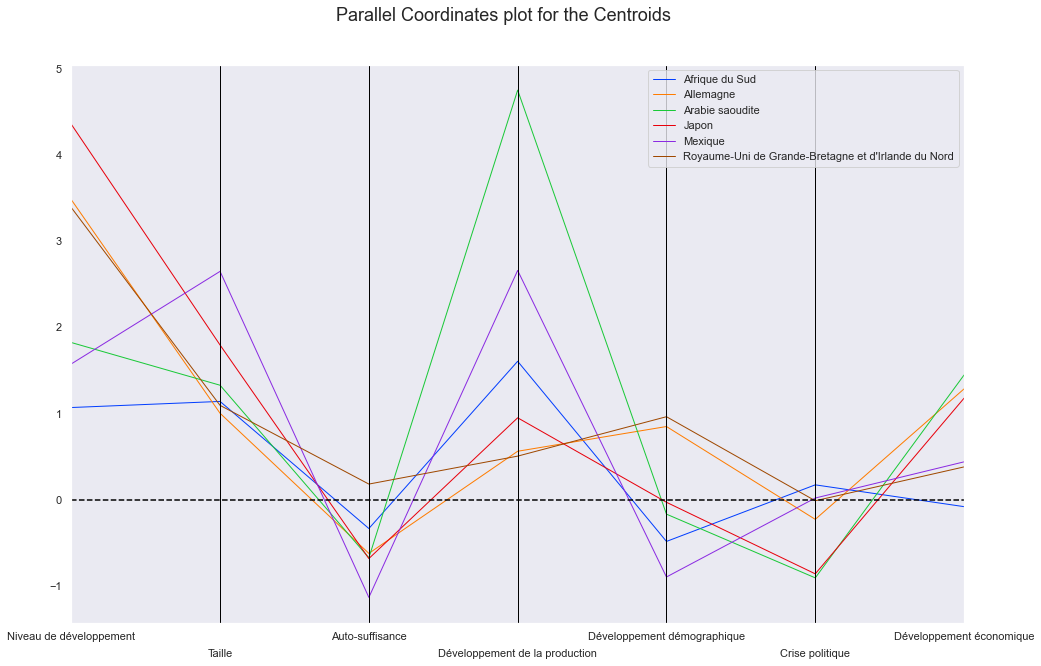

In [181]:
display_parallel_coordinates_centroids(bm, lw=1)
plt.axhline(y=0, color='black', linestyle='dashed')

> **Small Market:**

In [149]:
vsmall_market.index

Index(['Antigua-et-Barbuda', 'Dominique', 'Grenade', 'Saint-Kitts-et-Nevis',
       'Saint-Vincent-et-les Grenadines', 'Sainte-Lucie', 'Samoa'],
      dtype='object', name='Pays')

In [156]:
vsm = data[(data.index.isin(["Antigua-et-Barbuda"])) |
           (data.index.isin(["Dominique"])) |
           (data.index.isin(["Grenade"]))|
           (data.index.isin(["Saint-Kitts-et-Nevis"])) |
           (data.index.isin(["Saint-Vincent-et-les Grenadines"])) |
           (data.index.isin(["Sainte-Lucie"])) |
           (data.index.isin(["Samoa"]))]
vsm

,Population,Evo population (%),Population urbaine (%),Evo population urbaine (%),Disponibilité (tonnes),Disponibilité (kg/habitant),Evo disponibilité (%),Importations (tonnes),Taux importation (%),Evo taux importation,Taux production (%),Evo taux production,PIB,Evo PIB (%),PIB/habitant,Stabilité politique,Evo stabilité politique (%),CPI,Evo CPI
Pays,,,,,,,,,,,,,,,,,,,
Antigua-et-Barbuda,92664.0,2.318802,27.715186,2.379908,5112.0,63.674890,39.852335,4156.0,100.837066,2.330311,0.264390,-2.011031,1370.351852,-4.610470,13993.320179,0.93,0.05,43.517241,0.450292
Dominique,71995.0,2.739922,74.109313,3.819661,2867.0,54.599208,-9.070784,3966.0,90.715033,-1.026813,9.284967,1.026813,506.614815,-12.081089,7037.685311,1.35,0.35,55.000000,-4.000000
Grenade,123663.0,3.081706,32.295836,3.166977,4063.0,45.794134,-9.260695,5729.0,90.570436,-1.225751,9.429564,0.825174,1043.412699,-1.716969,9272.883756,1.03,0.01,53.000000,-3.000000
Saint-Kitts-et-Nevis,47642.0,-0.305516,36.780572,3.815392,2787.0,70.175895,-9.688817,3609.0,99.730807,2.242962,0.269193,-2.242962,927.451852,-4.501632,17433.633186,0.93,0.30,43.517241,0.450292
Saint-Vincent-et-les Grenadines,104632.0,-1.256099,56.136746,4.278588,7288.0,74.753708,1.830881,7232.0,94.202232,0.047825,5.807357,-0.051255,809.681481,4.551976,7298.372827,1.03,0.01,59.000000,-1.000000
Sainte-Lucie,179237.0,1.600789,19.047964,3.344836,10423.0,55.070382,-3.766696,8640.0,86.735017,2.499861,13.264983,-2.499861,1616.774074,-13.333625,8804.664206,0.87,-0.15,56.000000,-4.000000
Samoa,214929.0,4.565932,16.656198,-1.791397,12562.0,65.019099,-25.202109,18208.0,97.420371,-0.037211,2.579629,0.037211,771.829937,-6.061988,3889.997362,1.16,-0.04,43.517241,0.450292


Ce groupe présente des caractéristiques de dépendance extreme à une production extérieure associée à une consommation par personne importante, ce qui est intéressant pour nous. Cependant aucun de ces pays n'a une population supérieure à 215'000 personnes et par conséquent les volumes importés resteront "faibles".

In [160]:
small_market1.index

Index(['Bahreïn', 'Cabo Verde', 'Cuba', 'Koweït', 'Macédoine du Nord',
       'Nouvelle-Calédonie', 'Polynésie française', 'Seychelles'],
      dtype='object', name='Pays')

In [162]:
sm1 = data[(data.index.isin(["Bahreïn"])) |
           (data.index.isin(["Cabo Verde"])) |
           (data.index.isin(["Cuba"]))|
           (data.index.isin(["Koweït"])) |
           (data.index.isin(["Macédoine du Nord"])) |
           (data.index.isin(["Nouvelle-Calédonie"])) |
           (data.index.isin(["Polynésie française"])) |
           (data.index.isin(["Seychelles"]))]
sm1

,Population,Evo population (%),Population urbaine (%),Evo population urbaine (%),Disponibilité (tonnes),Disponibilité (kg/habitant),Evo disponibilité (%),Importations (tonnes),Taux importation (%),Evo taux importation,Taux production (%),Evo taux production,PIB,Evo PIB (%),PIB/habitant,Stabilité politique,Evo stabilité politique (%),CPI,Evo CPI
Pays,,,,,,,,,,,,,,,,,,,
Bahreïn,1477469.0,4.810235,102.851227,19.682929,556379.985674,48.122607,18.568216,0.0,87.519589,-0.015678,12.833718,0.587576,33903.884596,5.177328,19925.001599,-0.590000,0.200000,42.000000,-1.000000
Cabo Verde,582640.0,4.342095,64.902513,8.181376,7925.000000,23.678704,27.908029,9709.0,94.519055,4.504221,5.480945,-4.504221,1703.697924,2.446574,3064.276546,0.880000,-0.010000,58.000000,-1.000000
Cuba,11300698.0,-0.364256,78.524778,0.513962,268474.000000,37.719351,57.133115,240694.0,96.152538,7.423965,3.847462,-7.423965,107352.000000,17.491518,9477.852873,0.600000,-0.090000,47.000000,0.000000
Koweït,4360444.0,7.716216,98.679745,6.176084,179070.000000,44.137283,6.688258,128335.0,70.015024,-1.126872,32.502225,2.957287,105948.765176,-3.160447,24809.039629,0.240000,0.290000,42.000000,1.000000
Macédoine du Nord,2111072.0,0.041513,57.844214,1.930288,34579.000000,18.075840,10.354261,33322.0,97.546529,1.181683,3.915156,-0.448764,12263.699877,14.909726,5886.461037,0.100000,0.450000,35.000000,-2.000000
Nouvelle-Calédonie,286403.0,0.935689,71.645548,7.777842,9426.000000,37.487596,12.318862,8564.0,91.940342,2.349381,8.126718,-2.282320,9708.737831,11.356022,34006.325197,-0.134246,-0.013743,43.517241,0.450292
Polynésie française,301920.0,2.854456,59.680710,4.165751,12358.000000,55.614931,2.211225,15744.0,96.297002,0.460625,3.702998,-0.460625,5816.889144,5.890520,20707.452774,-0.134246,-0.013743,43.517241,0.450292
Seychelles,105530.0,4.996617,52.409741,5.130301,3105.000000,32.576803,7.938148,2719.0,86.814066,1.445149,14.372438,-0.258645,1058.881171,-25.729486,10766.786689,0.720000,-0.010000,66.000000,0.450292


In [184]:
sm1_ = data_pca[(data_pca.index.isin(["Bahreïn"])) |
           (data_pca.index.isin(["Cabo Verde"])) |
           (data_pca.index.isin(["Cuba"]))|
           (data_pca.index.isin(["Koweït"])) |
           (data_pca.index.isin(["Macédoine du Nord"])) |
           (data_pca.index.isin(["Nouvelle-Calédonie"])) |
           (data_pca.index.isin(["Polynésie française"])) |
           (data_pca.index.isin(["Seychelles"]))]
sm1_["Cluster"] = sm1_.index

C:\Users\MSI\AppData\Local\Temp\ipykernel_14884\1035534159.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm1_["Cluster"] = sm1_.index


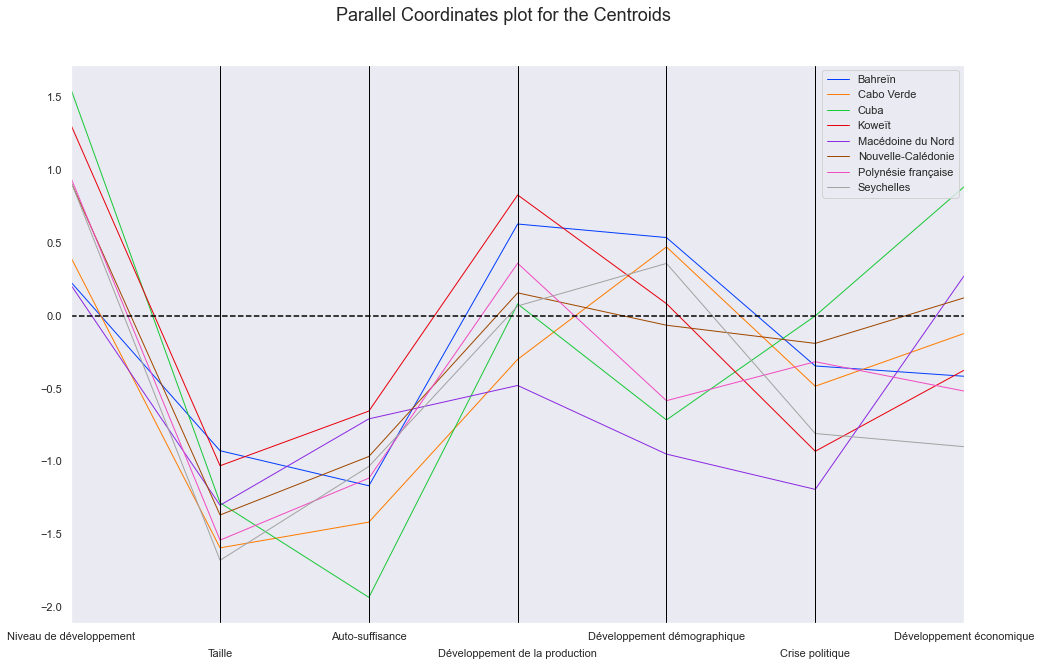

In [185]:
display_parallel_coordinates_centroids(sm1_, lw=1)
plt.axhline(y=0, color='black', linestyle='dashed')

In [186]:
small_market2.index

Index(['Qatar', 'Émirats arabes unis'], dtype='object', name='Pays')

On choisit ici d'ajouer Oman à ce groupe, du fait de caractéristiques très proches notamment mis en avant par la méthode CAH.

In [187]:
sm2 = data[(data.index.isin(["Qatar"])) |
           (data.index.isin(["Émirats arabes unis"])) |
           (data.index.isin(["Oman"]))]
sm2

,Population,Evo population (%),Population urbaine (%),Evo population urbaine (%),Disponibilité (tonnes),Disponibilité (kg/habitant),Evo disponibilité (%),Importations (tonnes),Taux importation (%),Evo taux importation,Taux production (%),Evo taux production,PIB,Evo PIB (%),PIB/habitant,Stabilité politique,Evo stabilité politique (%),CPI,Evo CPI
Pays,,,,,,,,,,,,,,,,,,,
Oman,4543399.0,3.304381,97.789562,21.710900,92088.000000,20.640943,-10.434038,112114.00,102.885390,-4.190681,6.981315,0.834522,63367.601873,-3.226770,12408.898140,0.37,-0.39,54.0,9.0
Qatar,2760385.0,6.366414,100.364696,8.880872,556379.985674,56.265101,18.568216,0.00,77.618793,-0.015678,22.381207,0.587576,146400.519343,-3.513864,50814.934450,0.67,-0.23,63.0,2.0
Émirats arabes unis,9287289.0,3.257921,91.976722,7.196864,268263.380000,49.948622,-13.538834,501819.51,102.382421,8.851297,11.027595,1.020265,358868.765175,0.510750,36284.547906,0.63,0.07,71.0,5.0


In [188]:
sm2_ = data_pca[(data_pca.index.isin(["Qatar"])) |
           (data_pca.index.isin(["Émirats arabes unis"])) |
           (data_pca.index.isin(["Oman"]))]
sm2_["Cluster"] = sm2_.index

C:\Users\MSI\AppData\Local\Temp\ipykernel_14884\4037783048.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm2_["Cluster"] = sm2_.index


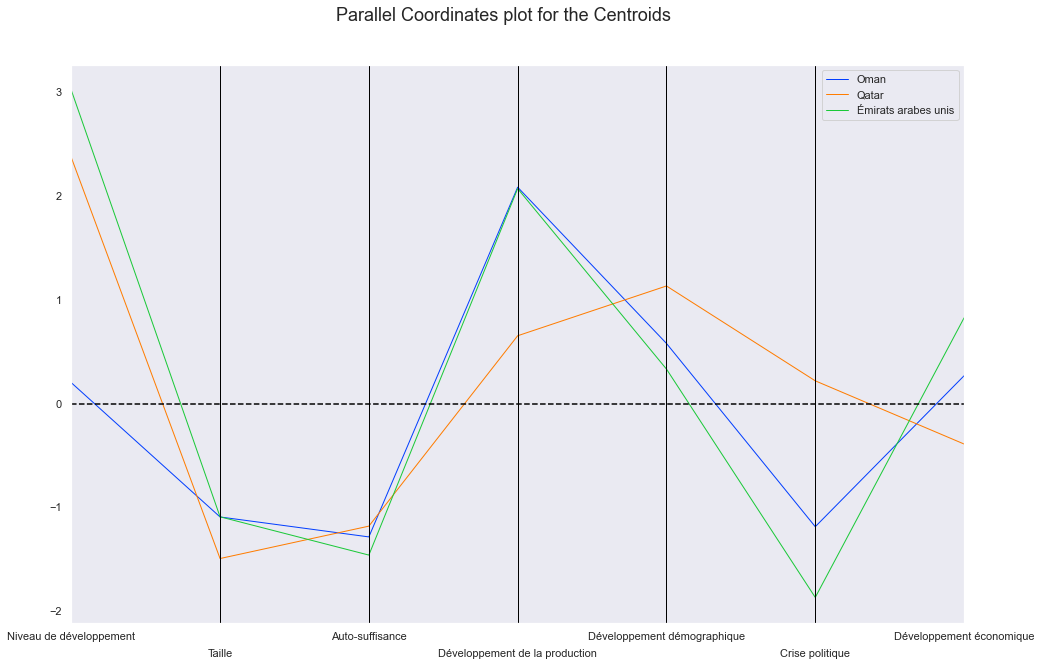

In [189]:
display_parallel_coordinates_centroids(sm2_, lw=1)
plt.axhline(y=0, color='black', linestyle='dashed')

> **Cas particuliers:**

In [174]:
pb = data[(data.index.isin(["Pays-Bas"]))]
pb

,Population,Evo population (%),Population urbaine (%),Evo population urbaine (%),Disponibilité (tonnes),Disponibilité (kg/habitant),Evo disponibilité (%),Importations (tonnes),Taux importation (%),Evo taux importation,Taux production (%),Evo taux production,PIB,Evo PIB (%),PIB/habitant,Stabilité politique,Evo stabilité politique (%),CPI,Evo CPI
Pays,,,,,,,,,,,,,,,,,,,
Pays-Bas,17434557.0,1.810575,90.895805,2.927828,257539.0,10.880505,-28.644647,274370.0,191.634924,88.429333,524.916659,135.107445,913865.39579,16.634656,53333.657572,0.85,-0.06,82.0,-1.0


In [175]:
hk = data[(data.index.isin(["Chine - RAS de Hong-Kong"]))]
hk

,Population,Evo population (%),Population urbaine (%),Evo population urbaine (%),Disponibilité (tonnes),Disponibilité (kg/habitant),Evo disponibilité (%),Importations (tonnes),Taux importation (%),Evo taux importation,Taux production (%),Evo taux production,PIB,Evo PIB (%),PIB/habitant,Stabilité politique,Evo stabilité politique (%),CPI,Evo CPI
Pays,,,,,,,,,,,,,,,,,,,
Chine - RAS de Hong-Kong,7500958.0,0.874551,100.622507,3.352242,186953.0,51.725044,62.290962,733859.0,116.358032,-190.607321,5.064876,-4.84858,349444.71301,8.91567,46611.39104,0.09,-0.66,77.0,0.0


> **Recommandations:**

> Les moins: 

Les pays des groupes **"Very Small Market"** et **"Small Market 1"** ne semblent pas être les meilleurs choix du fait du faible potentiel que représente leurs marchés.

***
> A étudier:

Les **Pays-Bas** présentent un certains intérêt mais demanderait une étude approndie afin de mieux cerner leur politique d'import/production.

**Hong-Kong** pourrait être une option très intéressante du fait de sa grande dépendance. Cependant l'instabilité politique et la potentielle relation très forte avec la production Chinoise sont des facteurs à étudier.

***
> Les plus:

Le **Small Market 2**, composé de plusieurs pays du Golfe (Qatar, EAU, Oman) est une excellente option. Ces 3 pays sont très dépendants de production extérieure tout en étant de grands consommateurs. Leur relative stabilité politique et économique sont aussi des atouts. Les **EAU** se distinguent tout de même des 2 autres pays sur ces points, en plus de représenter un marché avec plus de potentiel.

Enfin, la perle rare pourrait se trouver au sein du groupe **"Big Market"**. On y trouve des pays développés qui, malgré leur capacité de production, ont des besoins importants du fait de la taille de leur population. L'**Allemagne** de part sa croissance à plusieurs niveau ainsi sa proximité coche beaucoup de cases. Mais le **Mexique** et le **Japon** de part le potentiel de leur marché sont aussi des options intéressantes. L'**Arabie Saoudite** est le pays le plus dépendant de ce groupe mais sont deficit de stabilité, comparé aux autres, et son visible choix d'accélérer sa production intérieure sont des facteurs à considérer.

***
> Remarques:

Il s'agit ici d'une première étude, basée uniquement sur des données quantitatives, afin de dresser un portrait initial des candidats potentiels à l'exportation de nos produits. Comme préciser lors de la présentation des outils stratégique d'autres facteurs sont à considérer avant de prendre une décision finale:
- La logistique - Évaluer le cout et la faisabilité du transport
- La culture - Impact sur l'abattage de la viande (procédé, lieu, ...)
- La fiscalité - Politique de taxes, ...
- La législation - Lois environnementales ou liées aux produits alimentaires
- ...

Enfin, si un marché "régional", comme celui du Golfe, semble plus intéressant qu'un marché simplement national, pourquoi ne pas étudier la faisabilité du développement d'une telle filière.